In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(6784163, 828)
(6784163, 8)
validation
(966999, 828)
(966999, 8)
test
(856741, 828)
(856741, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/679 [..............................] - ETA: 15:31 - loss: 2.1864 - STD: 0.0498 - MAE: 0.2199

  5/679 [..............................] - ETA: 10s - loss: 2.0984 - STD: 0.0525 - MAE: 0.2164  

  8/679 [..............................] - ETA: 11s - loss: 2.0861 - STD: 0.0480 - MAE: 0.2163

 12/679 [..............................] - ETA: 10s - loss: 2.0754 - STD: 0.0412 - MAE: 0.2166

 16/679 [..............................] - ETA: 10s - loss: 2.0690 - STD: 0.0384 - MAE: 0.2166

 20/679 [..............................] - ETA: 10s - loss: 2.0622 - STD: 0.0376 - MAE: 0.2165

 24/679 [>.............................] - ETA: 10s - loss: 2.0549 - STD: 0.0378 - MAE: 0.2163

 28/679 [>.............................] - ETA: 10s - loss: 2.0433 - STD: 0.0379 - MAE: 0.2159

 32/679 [>.............................] - ETA: 10s - loss: 2.0295 - STD: 0.0396 - MAE: 0.2153

 36/679 [>.............................] - ETA: 10s - loss: 2.0152 - STD: 0.0425 - MAE: 0.2145

 40/679 [>.............................] - ETA: 10s - loss: 2.0017 - STD: 0.0459 - MAE: 0.2137

 44/679 [>.............................] - ETA: 9s - loss: 1.9880 - STD: 0.0485 - MAE: 0.2130 

 48/679 [=>............................] - ETA: 9s - loss: 1.9743 - STD: 0.0512 - MAE: 0.2122

 52/679 [=>............................] - ETA: 9s - loss: 1.9606 - STD: 0.0535 - MAE: 0.2115

 56/679 [=>............................] - ETA: 9s - loss: 1.9466 - STD: 0.0560 - MAE: 0.2107

 60/679 [=>............................] - ETA: 9s - loss: 1.9317 - STD: 0.0585 - MAE: 0.2099

 64/679 [=>............................] - ETA: 9s - loss: 1.9162 - STD: 0.0609 - MAE: 0.2091

 68/679 [==>...........................] - ETA: 9s - loss: 1.8998 - STD: 0.0634 - MAE: 0.2081

 72/679 [==>...........................] - ETA: 9s - loss: 1.8826 - STD: 0.0660 - MAE: 0.2071

 76/679 [==>...........................] - ETA: 9s - loss: 1.8649 - STD: 0.0688 - MAE: 0.2060

 80/679 [==>...........................] - ETA: 9s - loss: 1.8479 - STD: 0.0716 - MAE: 0.2049

 84/679 [==>...........................] - ETA: 9s - loss: 1.8321 - STD: 0.0743 - MAE: 0.2039

 88/679 [==>...........................] - ETA: 9s - loss: 1.8172 - STD: 0.0770 - MAE: 0.2028

 92/679 [===>..........................] - ETA: 9s - loss: 1.8026 - STD: 0.0795 - MAE: 0.2018

 95/679 [===>..........................] - ETA: 9s - loss: 1.7918 - STD: 0.0812 - MAE: 0.2011

 99/679 [===>..........................] - ETA: 9s - loss: 1.7785 - STD: 0.0835 - MAE: 0.2002

103/679 [===>..........................] - ETA: 9s - loss: 1.7657 - STD: 0.0856 - MAE: 0.1993

107/679 [===>..........................] - ETA: 8s - loss: 1.7534 - STD: 0.0877 - MAE: 0.1984

111/679 [===>..........................] - ETA: 8s - loss: 1.7420 - STD: 0.0897 - MAE: 0.1975

115/679 [====>.........................] - ETA: 8s - loss: 1.7310 - STD: 0.0916 - MAE: 0.1967

119/679 [====>.........................] - ETA: 8s - loss: 1.7205 - STD: 0.0935 - MAE: 0.1959

123/679 [====>.........................] - ETA: 8s - loss: 1.7103 - STD: 0.0953 - MAE: 0.1951

127/679 [====>.........................] - ETA: 8s - loss: 1.7006 - STD: 0.0971 - MAE: 0.1944

131/679 [====>.........................] - ETA: 8s - loss: 1.6912 - STD: 0.0987 - MAE: 0.1936

135/679 [====>.........................] - ETA: 8s - loss: 1.6820 - STD: 0.1003 - MAE: 0.1929

139/679 [=====>........................] - ETA: 8s - loss: 1.6730 - STD: 0.1018 - MAE: 0.1922

143/679 [=====>........................] - ETA: 8s - loss: 1.6646 - STD: 0.1033 - MAE: 0.1915

147/679 [=====>........................] - ETA: 8s - loss: 1.6564 - STD: 0.1048 - MAE: 0.1909

151/679 [=====>........................] - ETA: 8s - loss: 1.6486 - STD: 0.1062 - MAE: 0.1903

155/679 [=====>........................] - ETA: 8s - loss: 1.6407 - STD: 0.1075 - MAE: 0.1896

159/679 [======>.......................] - ETA: 8s - loss: 1.6333 - STD: 0.1088 - MAE: 0.1890

163/679 [======>.......................] - ETA: 8s - loss: 1.6261 - STD: 0.1101 - MAE: 0.1884

167/679 [======>.......................] - ETA: 8s - loss: 1.6196 - STD: 0.1113 - MAE: 0.1879

171/679 [======>.......................] - ETA: 7s - loss: 1.6131 - STD: 0.1125 - MAE: 0.1873

175/679 [======>.......................] - ETA: 7s - loss: 1.6067 - STD: 0.1137 - MAE: 0.1868

179/679 [======>.......................] - ETA: 7s - loss: 1.6004 - STD: 0.1148 - MAE: 0.1863

183/679 [=======>......................] - ETA: 7s - loss: 1.5942 - STD: 0.1159 - MAE: 0.1858

187/679 [=======>......................] - ETA: 7s - loss: 1.5883 - STD: 0.1169 - MAE: 0.1853

191/679 [=======>......................] - ETA: 7s - loss: 1.5826 - STD: 0.1179 - MAE: 0.1848

195/679 [=======>......................] - ETA: 7s - loss: 1.5768 - STD: 0.1189 - MAE: 0.1843

199/679 [=======>......................] - ETA: 7s - loss: 1.5712 - STD: 0.1199 - MAE: 0.1838

203/679 [=======>......................] - ETA: 7s - loss: 1.5659 - STD: 0.1209 - MAE: 0.1834

207/679 [========>.....................] - ETA: 7s - loss: 1.5606 - STD: 0.1218 - MAE: 0.1829

211/679 [========>.....................] - ETA: 7s - loss: 1.5556 - STD: 0.1227 - MAE: 0.1825

215/679 [========>.....................] - ETA: 7s - loss: 1.5506 - STD: 0.1236 - MAE: 0.1820

219/679 [========>.....................] - ETA: 7s - loss: 1.5459 - STD: 0.1244 - MAE: 0.1816

223/679 [========>.....................] - ETA: 7s - loss: 1.5415 - STD: 0.1252 - MAE: 0.1813

227/679 [=========>....................] - ETA: 7s - loss: 1.5370 - STD: 0.1260 - MAE: 0.1809

231/679 [=========>....................] - ETA: 6s - loss: 1.5327 - STD: 0.1268 - MAE: 0.1805

235/679 [=========>....................] - ETA: 6s - loss: 1.5285 - STD: 0.1275 - MAE: 0.1801

239/679 [=========>....................] - ETA: 6s - loss: 1.5241 - STD: 0.1283 - MAE: 0.1797

243/679 [=========>....................] - ETA: 6s - loss: 1.5201 - STD: 0.1290 - MAE: 0.1794

247/679 [=========>....................] - ETA: 6s - loss: 1.5162 - STD: 0.1297 - MAE: 0.1790

251/679 [==========>...................] - ETA: 6s - loss: 1.5125 - STD: 0.1304 - MAE: 0.1787

255/679 [==========>...................] - ETA: 6s - loss: 1.5087 - STD: 0.1311 - MAE: 0.1784

259/679 [==========>...................] - ETA: 6s - loss: 1.5051 - STD: 0.1317 - MAE: 0.1781

263/679 [==========>...................] - ETA: 6s - loss: 1.5016 - STD: 0.1323 - MAE: 0.1777

267/679 [==========>...................] - ETA: 6s - loss: 1.4981 - STD: 0.1330 - MAE: 0.1774

270/679 [==========>...................] - ETA: 6s - loss: 1.4955 - STD: 0.1334 - MAE: 0.1772

274/679 [===========>..................] - ETA: 6s - loss: 1.4920 - STD: 0.1340 - MAE: 0.1769

278/679 [===========>..................] - ETA: 6s - loss: 1.4885 - STD: 0.1346 - MAE: 0.1766

282/679 [===========>..................] - ETA: 6s - loss: 1.4852 - STD: 0.1352 - MAE: 0.1763

286/679 [===========>..................] - ETA: 6s - loss: 1.4820 - STD: 0.1358 - MAE: 0.1760

290/679 [===========>..................] - ETA: 6s - loss: 1.4789 - STD: 0.1363 - MAE: 0.1757

294/679 [===========>..................] - ETA: 6s - loss: 1.4757 - STD: 0.1368 - MAE: 0.1755

298/679 [============>.................] - ETA: 5s - loss: 1.4726 - STD: 0.1374 - MAE: 0.1752

301/679 [============>.................] - ETA: 5s - loss: 1.4704 - STD: 0.1378 - MAE: 0.1750

305/679 [============>.................] - ETA: 5s - loss: 1.4674 - STD: 0.1383 - MAE: 0.1747

309/679 [============>.................] - ETA: 5s - loss: 1.4645 - STD: 0.1388 - MAE: 0.1745

313/679 [============>.................] - ETA: 5s - loss: 1.4617 - STD: 0.1393 - MAE: 0.1742

317/679 [=============>................] - ETA: 5s - loss: 1.4588 - STD: 0.1397 - MAE: 0.1740

321/679 [=============>................] - ETA: 5s - loss: 1.4561 - STD: 0.1402 - MAE: 0.1737

325/679 [=============>................] - ETA: 5s - loss: 1.4533 - STD: 0.1407 - MAE: 0.1735

329/679 [=============>................] - ETA: 5s - loss: 1.4505 - STD: 0.1412 - MAE: 0.1732

333/679 [=============>................] - ETA: 5s - loss: 1.4479 - STD: 0.1416 - MAE: 0.1730

337/679 [=============>................] - ETA: 5s - loss: 1.4454 - STD: 0.1421 - MAE: 0.1728

341/679 [==============>...............] - ETA: 5s - loss: 1.4433 - STD: 0.1425 - MAE: 0.1726

345/679 [==============>...............] - ETA: 5s - loss: 1.4412 - STD: 0.1429 - MAE: 0.1723

349/679 [==============>...............] - ETA: 5s - loss: 1.4390 - STD: 0.1433 - MAE: 0.1721

353/679 [==============>...............] - ETA: 5s - loss: 1.4367 - STD: 0.1438 - MAE: 0.1719

357/679 [==============>...............] - ETA: 5s - loss: 1.4343 - STD: 0.1441 - MAE: 0.1717

361/679 [==============>...............] - ETA: 4s - loss: 1.4320 - STD: 0.1445 - MAE: 0.1715

365/679 [===============>..............] - ETA: 4s - loss: 1.4297 - STD: 0.1449 - MAE: 0.1713

369/679 [===============>..............] - ETA: 4s - loss: 1.4274 - STD: 0.1453 - MAE: 0.1711

373/679 [===============>..............] - ETA: 4s - loss: 1.4250 - STD: 0.1457 - MAE: 0.1709

377/679 [===============>..............] - ETA: 4s - loss: 1.4227 - STD: 0.1461 - MAE: 0.1707

381/679 [===============>..............] - ETA: 4s - loss: 1.4204 - STD: 0.1464 - MAE: 0.1705

385/679 [================>.............] - ETA: 4s - loss: 1.4182 - STD: 0.1468 - MAE: 0.1703

389/679 [================>.............] - ETA: 4s - loss: 1.4160 - STD: 0.1472 - MAE: 0.1701

393/679 [================>.............] - ETA: 4s - loss: 1.4137 - STD: 0.1475 - MAE: 0.1699

397/679 [================>.............] - ETA: 4s - loss: 1.4115 - STD: 0.1479 - MAE: 0.1697

401/679 [================>.............] - ETA: 4s - loss: 1.4093 - STD: 0.1483 - MAE: 0.1695

405/679 [================>.............] - ETA: 4s - loss: 1.4071 - STD: 0.1486 - MAE: 0.1693

409/679 [=================>............] - ETA: 4s - loss: 1.4050 - STD: 0.1489 - MAE: 0.1691

413/679 [=================>............] - ETA: 4s - loss: 1.4030 - STD: 0.1493 - MAE: 0.1689

417/679 [=================>............] - ETA: 4s - loss: 1.4010 - STD: 0.1496 - MAE: 0.1688

421/679 [=================>............] - ETA: 4s - loss: 1.3991 - STD: 0.1499 - MAE: 0.1686

425/679 [=================>............] - ETA: 3s - loss: 1.3971 - STD: 0.1503 - MAE: 0.1684

429/679 [=================>............] - ETA: 3s - loss: 1.3952 - STD: 0.1506 - MAE: 0.1682

433/679 [==================>...........] - ETA: 3s - loss: 1.3932 - STD: 0.1509 - MAE: 0.1680

437/679 [==================>...........] - ETA: 3s - loss: 1.3913 - STD: 0.1512 - MAE: 0.1679

441/679 [==================>...........] - ETA: 3s - loss: 1.3895 - STD: 0.1515 - MAE: 0.1677

445/679 [==================>...........] - ETA: 3s - loss: 1.3877 - STD: 0.1518 - MAE: 0.1675

449/679 [==================>...........] - ETA: 3s - loss: 1.3860 - STD: 0.1521 - MAE: 0.1674

453/679 [===================>..........] - ETA: 3s - loss: 1.3842 - STD: 0.1524 - MAE: 0.1672

457/679 [===================>..........] - ETA: 3s - loss: 1.3825 - STD: 0.1527 - MAE: 0.1671

461/679 [===================>..........] - ETA: 3s - loss: 1.3808 - STD: 0.1530 - MAE: 0.1669

465/679 [===================>..........] - ETA: 3s - loss: 1.3790 - STD: 0.1533 - MAE: 0.1667

469/679 [===================>..........] - ETA: 3s - loss: 1.3772 - STD: 0.1536 - MAE: 0.1666

473/679 [===================>..........] - ETA: 3s - loss: 1.3756 - STD: 0.1538 - MAE: 0.1664

477/679 [====================>.........] - ETA: 3s - loss: 1.3740 - STD: 0.1541 - MAE: 0.1663

481/679 [====================>.........] - ETA: 3s - loss: 1.3725 - STD: 0.1544 - MAE: 0.1661

485/679 [====================>.........] - ETA: 3s - loss: 1.3709 - STD: 0.1547 - MAE: 0.1660

489/679 [====================>.........] - ETA: 2s - loss: 1.3694 - STD: 0.1549 - MAE: 0.1658

493/679 [====================>.........] - ETA: 2s - loss: 1.3678 - STD: 0.1552 - MAE: 0.1657

497/679 [====================>.........] - ETA: 2s - loss: 1.3662 - STD: 0.1554 - MAE: 0.1656

501/679 [=====================>........] - ETA: 2s - loss: 1.3647 - STD: 0.1557 - MAE: 0.1654

505/679 [=====================>........] - ETA: 2s - loss: 1.3631 - STD: 0.1560 - MAE: 0.1653

509/679 [=====================>........] - ETA: 2s - loss: 1.3616 - STD: 0.1562 - MAE: 0.1651

513/679 [=====================>........] - ETA: 2s - loss: 1.3601 - STD: 0.1565 - MAE: 0.1650

517/679 [=====================>........] - ETA: 2s - loss: 1.3586 - STD: 0.1567 - MAE: 0.1648

521/679 [======================>.......] - ETA: 2s - loss: 1.3571 - STD: 0.1569 - MAE: 0.1647

525/679 [======================>.......] - ETA: 2s - loss: 1.3556 - STD: 0.1572 - MAE: 0.1646

529/679 [======================>.......] - ETA: 2s - loss: 1.3541 - STD: 0.1574 - MAE: 0.1644

533/679 [======================>.......] - ETA: 2s - loss: 1.3526 - STD: 0.1576 - MAE: 0.1643

537/679 [======================>.......] - ETA: 2s - loss: 1.3512 - STD: 0.1579 - MAE: 0.1642

541/679 [======================>.......] - ETA: 2s - loss: 1.3497 - STD: 0.1581 - MAE: 0.1640

545/679 [=======================>......] - ETA: 2s - loss: 1.3482 - STD: 0.1583 - MAE: 0.1639

549/679 [=======================>......] - ETA: 2s - loss: 1.3468 - STD: 0.1586 - MAE: 0.1638

553/679 [=======================>......] - ETA: 1s - loss: 1.3454 - STD: 0.1588 - MAE: 0.1636

557/679 [=======================>......] - ETA: 1s - loss: 1.3440 - STD: 0.1590 - MAE: 0.1635

561/679 [=======================>......] - ETA: 1s - loss: 1.3426 - STD: 0.1592 - MAE: 0.1634

565/679 [=======================>......] - ETA: 1s - loss: 1.3413 - STD: 0.1594 - MAE: 0.1633

569/679 [========================>.....] - ETA: 1s - loss: 1.3401 - STD: 0.1597 - MAE: 0.1631

573/679 [========================>.....] - ETA: 1s - loss: 1.3387 - STD: 0.1599 - MAE: 0.1630

575/679 [========================>.....] - ETA: 1s - loss: 1.3382 - STD: 0.1600 - MAE: 0.1630

579/679 [========================>.....] - ETA: 1s - loss: 1.3370 - STD: 0.1602 - MAE: 0.1628

583/679 [========================>.....] - ETA: 1s - loss: 1.3357 - STD: 0.1604 - MAE: 0.1627

587/679 [========================>.....] - ETA: 1s - loss: 1.3345 - STD: 0.1606 - MAE: 0.1626

591/679 [=========================>....] - ETA: 1s - loss: 1.3333 - STD: 0.1608 - MAE: 0.1625

595/679 [=========================>....] - ETA: 1s - loss: 1.3320 - STD: 0.1610 - MAE: 0.1624

599/679 [=========================>....] - ETA: 1s - loss: 1.3307 - STD: 0.1612 - MAE: 0.1623

603/679 [=========================>....] - ETA: 1s - loss: 1.3294 - STD: 0.1614 - MAE: 0.1622

607/679 [=========================>....] - ETA: 1s - loss: 1.3282 - STD: 0.1616 - MAE: 0.1620

611/679 [=========================>....] - ETA: 1s - loss: 1.3269 - STD: 0.1618 - MAE: 0.1619

615/679 [==========================>...] - ETA: 1s - loss: 1.3257 - STD: 0.1620 - MAE: 0.1618

619/679 [==========================>...] - ETA: 0s - loss: 1.3245 - STD: 0.1621 - MAE: 0.1617

623/679 [==========================>...] - ETA: 0s - loss: 1.3235 - STD: 0.1623 - MAE: 0.1616

627/679 [==========================>...] - ETA: 0s - loss: 1.3224 - STD: 0.1625 - MAE: 0.1615

631/679 [==========================>...] - ETA: 0s - loss: 1.3213 - STD: 0.1627 - MAE: 0.1614

635/679 [===========================>..] - ETA: 0s - loss: 1.3201 - STD: 0.1629 - MAE: 0.1613

639/679 [===========================>..] - ETA: 0s - loss: 1.3190 - STD: 0.1631 - MAE: 0.1612

643/679 [===========================>..] - ETA: 0s - loss: 1.3178 - STD: 0.1633 - MAE: 0.1611

647/679 [===========================>..] - ETA: 0s - loss: 1.3167 - STD: 0.1634 - MAE: 0.1610

651/679 [===========================>..] - ETA: 0s - loss: 1.3155 - STD: 0.1636 - MAE: 0.1609

655/679 [===========================>..] - ETA: 0s - loss: 1.3143 - STD: 0.1638 - MAE: 0.1608

659/679 [============================>.] - ETA: 0s - loss: 1.3132 - STD: 0.1640 - MAE: 0.1606

663/679 [============================>.] - ETA: 0s - loss: 1.3120 - STD: 0.1641 - MAE: 0.1605

667/679 [============================>.] - ETA: 0s - loss: 1.3111 - STD: 0.1643 - MAE: 0.1604

671/679 [============================>.] - ETA: 0s - loss: 1.3100 - STD: 0.1645 - MAE: 0.1603

675/679 [============================>.] - ETA: 0s - loss: 1.3089 - STD: 0.1646 - MAE: 0.1602

679/679 [==============================] - ETA: 0s - loss: 1.3079 - STD: 0.1648 - MAE: 0.1602

679/679 [==============================] - 14s 19ms/step - loss: 1.3079 - STD: 0.1648 - MAE: 0.1602 - val_loss: 1.1612 - val_STD: 0.1949 - val_MAE: 0.1432


Epoch 2/10000


  1/679 [..............................] - ETA: 26s - loss: 1.1229 - STD: 0.1928 - MAE: 0.1434

  5/679 [..............................] - ETA: 10s - loss: 1.1252 - STD: 0.1928 - MAE: 0.1434

  8/679 [..............................] - ETA: 10s - loss: 1.1230 - STD: 0.1928 - MAE: 0.1433

 12/679 [..............................] - ETA: 10s - loss: 1.1197 - STD: 0.1927 - MAE: 0.1431

 16/679 [..............................] - ETA: 10s - loss: 1.1172 - STD: 0.1931 - MAE: 0.1428

 20/679 [..............................] - ETA: 10s - loss: 1.1189 - STD: 0.1932 - MAE: 0.1429

 24/679 [>.............................] - ETA: 9s - loss: 1.1191 - STD: 0.1932 - MAE: 0.1428 

 28/679 [>.............................] - ETA: 9s - loss: 1.1183 - STD: 0.1934 - MAE: 0.1428

 32/679 [>.............................] - ETA: 9s - loss: 1.1189 - STD: 0.1935 - MAE: 0.1428

 36/679 [>.............................] - ETA: 9s - loss: 1.1182 - STD: 0.1935 - MAE: 0.1427

 40/679 [>.............................] - ETA: 9s - loss: 1.1178 - STD: 0.1936 - MAE: 0.1427

 44/679 [>.............................] - ETA: 9s - loss: 1.1184 - STD: 0.1937 - MAE: 0.1426

 48/679 [=>............................] - ETA: 9s - loss: 1.1195 - STD: 0.1938 - MAE: 0.1427

 52/679 [=>............................] - ETA: 9s - loss: 1.1194 - STD: 0.1939 - MAE: 0.1426

 56/679 [=>............................] - ETA: 9s - loss: 1.1188 - STD: 0.1940 - MAE: 0.1426

 60/679 [=>............................] - ETA: 9s - loss: 1.1187 - STD: 0.1940 - MAE: 0.1426

 64/679 [=>............................] - ETA: 9s - loss: 1.1183 - STD: 0.1941 - MAE: 0.1425

 68/679 [==>...........................] - ETA: 9s - loss: 1.1183 - STD: 0.1940 - MAE: 0.1425

 72/679 [==>...........................] - ETA: 9s - loss: 1.1182 - STD: 0.1940 - MAE: 0.1425

 76/679 [==>...........................] - ETA: 9s - loss: 1.1177 - STD: 0.1941 - MAE: 0.1425

 80/679 [==>...........................] - ETA: 9s - loss: 1.1179 - STD: 0.1942 - MAE: 0.1424

 84/679 [==>...........................] - ETA: 9s - loss: 1.1177 - STD: 0.1942 - MAE: 0.1424

 88/679 [==>...........................] - ETA: 8s - loss: 1.1172 - STD: 0.1943 - MAE: 0.1424

 92/679 [===>..........................] - ETA: 8s - loss: 1.1165 - STD: 0.1943 - MAE: 0.1423

 96/679 [===>..........................] - ETA: 8s - loss: 1.1158 - STD: 0.1944 - MAE: 0.1423

100/679 [===>..........................] - ETA: 8s - loss: 1.1157 - STD: 0.1945 - MAE: 0.1422

104/679 [===>..........................] - ETA: 8s - loss: 1.1159 - STD: 0.1945 - MAE: 0.1422

108/679 [===>..........................] - ETA: 8s - loss: 1.1158 - STD: 0.1946 - MAE: 0.1422

112/679 [===>..........................] - ETA: 8s - loss: 1.1154 - STD: 0.1946 - MAE: 0.1421

116/679 [====>.........................] - ETA: 8s - loss: 1.1146 - STD: 0.1947 - MAE: 0.1421

120/679 [====>.........................] - ETA: 8s - loss: 1.1139 - STD: 0.1947 - MAE: 0.1420

124/679 [====>.........................] - ETA: 8s - loss: 1.1133 - STD: 0.1948 - MAE: 0.1420

128/679 [====>.........................] - ETA: 8s - loss: 1.1130 - STD: 0.1948 - MAE: 0.1420

132/679 [====>.........................] - ETA: 8s - loss: 1.1128 - STD: 0.1949 - MAE: 0.1419

136/679 [=====>........................] - ETA: 8s - loss: 1.1125 - STD: 0.1949 - MAE: 0.1419

140/679 [=====>........................] - ETA: 8s - loss: 1.1123 - STD: 0.1950 - MAE: 0.1419

144/679 [=====>........................] - ETA: 8s - loss: 1.1122 - STD: 0.1950 - MAE: 0.1418

148/679 [=====>........................] - ETA: 8s - loss: 1.1121 - STD: 0.1950 - MAE: 0.1418

152/679 [=====>........................] - ETA: 8s - loss: 1.1121 - STD: 0.1950 - MAE: 0.1418

156/679 [=====>........................] - ETA: 8s - loss: 1.1118 - STD: 0.1951 - MAE: 0.1418

160/679 [======>.......................] - ETA: 7s - loss: 1.1114 - STD: 0.1951 - MAE: 0.1418

164/679 [======>.......................] - ETA: 7s - loss: 1.1108 - STD: 0.1952 - MAE: 0.1417

168/679 [======>.......................] - ETA: 7s - loss: 1.1106 - STD: 0.1952 - MAE: 0.1417

172/679 [======>.......................] - ETA: 7s - loss: 1.1104 - STD: 0.1952 - MAE: 0.1417

176/679 [======>.......................] - ETA: 7s - loss: 1.1099 - STD: 0.1952 - MAE: 0.1416

180/679 [======>.......................] - ETA: 7s - loss: 1.1093 - STD: 0.1953 - MAE: 0.1416

184/679 [=======>......................] - ETA: 7s - loss: 1.1086 - STD: 0.1953 - MAE: 0.1415

188/679 [=======>......................] - ETA: 7s - loss: 1.1083 - STD: 0.1954 - MAE: 0.1415

192/679 [=======>......................] - ETA: 7s - loss: 1.1076 - STD: 0.1954 - MAE: 0.1415

196/679 [=======>......................] - ETA: 7s - loss: 1.1071 - STD: 0.1955 - MAE: 0.1414

200/679 [=======>......................] - ETA: 7s - loss: 1.1067 - STD: 0.1955 - MAE: 0.1414

204/679 [========>.....................] - ETA: 7s - loss: 1.1066 - STD: 0.1956 - MAE: 0.1414

208/679 [========>.....................] - ETA: 7s - loss: 1.1062 - STD: 0.1956 - MAE: 0.1413

212/679 [========>.....................] - ETA: 7s - loss: 1.1058 - STD: 0.1957 - MAE: 0.1413

216/679 [========>.....................] - ETA: 7s - loss: 1.1054 - STD: 0.1958 - MAE: 0.1412

220/679 [========>.....................] - ETA: 7s - loss: 1.1049 - STD: 0.1958 - MAE: 0.1412

224/679 [========>.....................] - ETA: 6s - loss: 1.1045 - STD: 0.1959 - MAE: 0.1411

228/679 [=========>....................] - ETA: 6s - loss: 1.1040 - STD: 0.1959 - MAE: 0.1411

232/679 [=========>....................] - ETA: 6s - loss: 1.1037 - STD: 0.1960 - MAE: 0.1411

236/679 [=========>....................] - ETA: 6s - loss: 1.1032 - STD: 0.1960 - MAE: 0.1410

240/679 [=========>....................] - ETA: 6s - loss: 1.1028 - STD: 0.1960 - MAE: 0.1410

244/679 [=========>....................] - ETA: 6s - loss: 1.1023 - STD: 0.1961 - MAE: 0.1409

248/679 [=========>....................] - ETA: 6s - loss: 1.1019 - STD: 0.1961 - MAE: 0.1409

252/679 [==========>...................] - ETA: 6s - loss: 1.1016 - STD: 0.1962 - MAE: 0.1409

256/679 [==========>...................] - ETA: 6s - loss: 1.1015 - STD: 0.1963 - MAE: 0.1408

260/679 [==========>...................] - ETA: 6s - loss: 1.1014 - STD: 0.1963 - MAE: 0.1408

264/679 [==========>...................] - ETA: 6s - loss: 1.1012 - STD: 0.1964 - MAE: 0.1408

268/679 [==========>...................] - ETA: 6s - loss: 1.1010 - STD: 0.1964 - MAE: 0.1408

272/679 [===========>..................] - ETA: 6s - loss: 1.1006 - STD: 0.1964 - MAE: 0.1407

276/679 [===========>..................] - ETA: 6s - loss: 1.1004 - STD: 0.1965 - MAE: 0.1407

280/679 [===========>..................] - ETA: 6s - loss: 1.1002 - STD: 0.1965 - MAE: 0.1407

284/679 [===========>..................] - ETA: 6s - loss: 1.1000 - STD: 0.1965 - MAE: 0.1406

288/679 [===========>..................] - ETA: 6s - loss: 1.0999 - STD: 0.1966 - MAE: 0.1406

292/679 [===========>..................] - ETA: 5s - loss: 1.0995 - STD: 0.1966 - MAE: 0.1406

296/679 [============>.................] - ETA: 5s - loss: 1.0992 - STD: 0.1967 - MAE: 0.1406

300/679 [============>.................] - ETA: 5s - loss: 1.0989 - STD: 0.1967 - MAE: 0.1405

304/679 [============>.................] - ETA: 5s - loss: 1.0987 - STD: 0.1967 - MAE: 0.1405

308/679 [============>.................] - ETA: 5s - loss: 1.0985 - STD: 0.1968 - MAE: 0.1405

312/679 [============>.................] - ETA: 5s - loss: 1.0985 - STD: 0.1968 - MAE: 0.1405

316/679 [============>.................] - ETA: 5s - loss: 1.0982 - STD: 0.1969 - MAE: 0.1404

320/679 [=============>................] - ETA: 5s - loss: 1.0978 - STD: 0.1969 - MAE: 0.1404

324/679 [=============>................] - ETA: 5s - loss: 1.0975 - STD: 0.1970 - MAE: 0.1403

328/679 [=============>................] - ETA: 5s - loss: 1.0972 - STD: 0.1970 - MAE: 0.1403

332/679 [=============>................] - ETA: 5s - loss: 1.0968 - STD: 0.1970 - MAE: 0.1403

336/679 [=============>................] - ETA: 5s - loss: 1.0964 - STD: 0.1970 - MAE: 0.1403

340/679 [==============>...............] - ETA: 5s - loss: 1.0959 - STD: 0.1971 - MAE: 0.1402

344/679 [==============>...............] - ETA: 5s - loss: 1.0955 - STD: 0.1972 - MAE: 0.1402

348/679 [==============>...............] - ETA: 5s - loss: 1.0951 - STD: 0.1972 - MAE: 0.1401

352/679 [==============>...............] - ETA: 5s - loss: 1.0947 - STD: 0.1973 - MAE: 0.1401

356/679 [==============>...............] - ETA: 4s - loss: 1.0943 - STD: 0.1973 - MAE: 0.1401

360/679 [==============>...............] - ETA: 4s - loss: 1.0940 - STD: 0.1974 - MAE: 0.1400

364/679 [===============>..............] - ETA: 4s - loss: 1.0936 - STD: 0.1974 - MAE: 0.1400

368/679 [===============>..............] - ETA: 4s - loss: 1.0933 - STD: 0.1974 - MAE: 0.1399

372/679 [===============>..............] - ETA: 4s - loss: 1.0929 - STD: 0.1975 - MAE: 0.1399

376/679 [===============>..............] - ETA: 4s - loss: 1.0925 - STD: 0.1975 - MAE: 0.1399

380/679 [===============>..............] - ETA: 4s - loss: 1.0921 - STD: 0.1976 - MAE: 0.1398

384/679 [===============>..............] - ETA: 4s - loss: 1.0918 - STD: 0.1976 - MAE: 0.1398

388/679 [================>.............] - ETA: 4s - loss: 1.0917 - STD: 0.1977 - MAE: 0.1398

392/679 [================>.............] - ETA: 4s - loss: 1.0913 - STD: 0.1977 - MAE: 0.1397

396/679 [================>.............] - ETA: 4s - loss: 1.0909 - STD: 0.1977 - MAE: 0.1397

400/679 [================>.............] - ETA: 4s - loss: 1.0906 - STD: 0.1978 - MAE: 0.1397

404/679 [================>.............] - ETA: 4s - loss: 1.0902 - STD: 0.1978 - MAE: 0.1396

408/679 [=================>............] - ETA: 4s - loss: 1.0899 - STD: 0.1979 - MAE: 0.1396

412/679 [=================>............] - ETA: 4s - loss: 1.0897 - STD: 0.1979 - MAE: 0.1396

416/679 [=================>............] - ETA: 4s - loss: 1.0894 - STD: 0.1980 - MAE: 0.1395

420/679 [=================>............] - ETA: 3s - loss: 1.0892 - STD: 0.1980 - MAE: 0.1395

424/679 [=================>............] - ETA: 3s - loss: 1.0889 - STD: 0.1980 - MAE: 0.1395

428/679 [=================>............] - ETA: 3s - loss: 1.0886 - STD: 0.1981 - MAE: 0.1394

432/679 [==================>...........] - ETA: 3s - loss: 1.0883 - STD: 0.1981 - MAE: 0.1394

436/679 [==================>...........] - ETA: 3s - loss: 1.0880 - STD: 0.1982 - MAE: 0.1394

440/679 [==================>...........] - ETA: 3s - loss: 1.0877 - STD: 0.1982 - MAE: 0.1394

444/679 [==================>...........] - ETA: 3s - loss: 1.0874 - STD: 0.1982 - MAE: 0.1393

448/679 [==================>...........] - ETA: 3s - loss: 1.0871 - STD: 0.1983 - MAE: 0.1393

452/679 [==================>...........] - ETA: 3s - loss: 1.0868 - STD: 0.1983 - MAE: 0.1393

455/679 [===================>..........] - ETA: 3s - loss: 1.0866 - STD: 0.1983 - MAE: 0.1392

459/679 [===================>..........] - ETA: 3s - loss: 1.0866 - STD: 0.1984 - MAE: 0.1392

463/679 [===================>..........] - ETA: 3s - loss: 1.0863 - STD: 0.1984 - MAE: 0.1392

467/679 [===================>..........] - ETA: 3s - loss: 1.0861 - STD: 0.1984 - MAE: 0.1392

471/679 [===================>..........] - ETA: 3s - loss: 1.0858 - STD: 0.1985 - MAE: 0.1391

475/679 [===================>..........] - ETA: 3s - loss: 1.0855 - STD: 0.1985 - MAE: 0.1391

479/679 [====================>.........] - ETA: 3s - loss: 1.0852 - STD: 0.1986 - MAE: 0.1391

483/679 [====================>.........] - ETA: 3s - loss: 1.0849 - STD: 0.1986 - MAE: 0.1390

487/679 [====================>.........] - ETA: 2s - loss: 1.0846 - STD: 0.1986 - MAE: 0.1390

491/679 [====================>.........] - ETA: 2s - loss: 1.0842 - STD: 0.1987 - MAE: 0.1390

495/679 [====================>.........] - ETA: 2s - loss: 1.0839 - STD: 0.1987 - MAE: 0.1389

499/679 [=====================>........] - ETA: 2s - loss: 1.0836 - STD: 0.1987 - MAE: 0.1389

503/679 [=====================>........] - ETA: 2s - loss: 1.0832 - STD: 0.1988 - MAE: 0.1389

507/679 [=====================>........] - ETA: 2s - loss: 1.0829 - STD: 0.1988 - MAE: 0.1388

511/679 [=====================>........] - ETA: 2s - loss: 1.0827 - STD: 0.1989 - MAE: 0.1388

515/679 [=====================>........] - ETA: 2s - loss: 1.0825 - STD: 0.1989 - MAE: 0.1388

519/679 [=====================>........] - ETA: 2s - loss: 1.0822 - STD: 0.1989 - MAE: 0.1388

523/679 [======================>.......] - ETA: 2s - loss: 1.0821 - STD: 0.1990 - MAE: 0.1387

527/679 [======================>.......] - ETA: 2s - loss: 1.0820 - STD: 0.1990 - MAE: 0.1387

531/679 [======================>.......] - ETA: 2s - loss: 1.0818 - STD: 0.1991 - MAE: 0.1387

535/679 [======================>.......] - ETA: 2s - loss: 1.0815 - STD: 0.1991 - MAE: 0.1387

539/679 [======================>.......] - ETA: 2s - loss: 1.0812 - STD: 0.1991 - MAE: 0.1386

543/679 [======================>.......] - ETA: 2s - loss: 1.0809 - STD: 0.1992 - MAE: 0.1386

547/679 [=======================>......] - ETA: 2s - loss: 1.0806 - STD: 0.1992 - MAE: 0.1386

551/679 [=======================>......] - ETA: 1s - loss: 1.0804 - STD: 0.1992 - MAE: 0.1386

555/679 [=======================>......] - ETA: 1s - loss: 1.0801 - STD: 0.1993 - MAE: 0.1385

559/679 [=======================>......] - ETA: 1s - loss: 1.0798 - STD: 0.1993 - MAE: 0.1385

563/679 [=======================>......] - ETA: 1s - loss: 1.0795 - STD: 0.1993 - MAE: 0.1385

567/679 [========================>.....] - ETA: 1s - loss: 1.0795 - STD: 0.1994 - MAE: 0.1385

571/679 [========================>.....] - ETA: 1s - loss: 1.0793 - STD: 0.1994 - MAE: 0.1384

575/679 [========================>.....] - ETA: 1s - loss: 1.0791 - STD: 0.1994 - MAE: 0.1384

579/679 [========================>.....] - ETA: 1s - loss: 1.0789 - STD: 0.1995 - MAE: 0.1384

583/679 [========================>.....] - ETA: 1s - loss: 1.0786 - STD: 0.1995 - MAE: 0.1384

587/679 [========================>.....] - ETA: 1s - loss: 1.0783 - STD: 0.1995 - MAE: 0.1383

591/679 [=========================>....] - ETA: 1s - loss: 1.0781 - STD: 0.1996 - MAE: 0.1383

595/679 [=========================>....] - ETA: 1s - loss: 1.0780 - STD: 0.1996 - MAE: 0.1383

599/679 [=========================>....] - ETA: 1s - loss: 1.0777 - STD: 0.1996 - MAE: 0.1383

603/679 [=========================>....] - ETA: 1s - loss: 1.0775 - STD: 0.1997 - MAE: 0.1382

607/679 [=========================>....] - ETA: 1s - loss: 1.0773 - STD: 0.1997 - MAE: 0.1382

611/679 [=========================>....] - ETA: 1s - loss: 1.0769 - STD: 0.1997 - MAE: 0.1382

615/679 [==========================>...] - ETA: 0s - loss: 1.0767 - STD: 0.1997 - MAE: 0.1382

619/679 [==========================>...] - ETA: 0s - loss: 1.0764 - STD: 0.1998 - MAE: 0.1381

623/679 [==========================>...] - ETA: 0s - loss: 1.0761 - STD: 0.1998 - MAE: 0.1381

627/679 [==========================>...] - ETA: 0s - loss: 1.0758 - STD: 0.1998 - MAE: 0.1381

631/679 [==========================>...] - ETA: 0s - loss: 1.0756 - STD: 0.1999 - MAE: 0.1380

635/679 [===========================>..] - ETA: 0s - loss: 1.0753 - STD: 0.1999 - MAE: 0.1380

639/679 [===========================>..] - ETA: 0s - loss: 1.0750 - STD: 0.1999 - MAE: 0.1380

643/679 [===========================>..] - ETA: 0s - loss: 1.0747 - STD: 0.2000 - MAE: 0.1380

647/679 [===========================>..] - ETA: 0s - loss: 1.0745 - STD: 0.2000 - MAE: 0.1379

651/679 [===========================>..] - ETA: 0s - loss: 1.0745 - STD: 0.2000 - MAE: 0.1379

655/679 [===========================>..] - ETA: 0s - loss: 1.0745 - STD: 0.2001 - MAE: 0.1379

659/679 [============================>.] - ETA: 0s - loss: 1.0744 - STD: 0.2001 - MAE: 0.1379

663/679 [============================>.] - ETA: 0s - loss: 1.0742 - STD: 0.2001 - MAE: 0.1379

667/679 [============================>.] - ETA: 0s - loss: 1.0739 - STD: 0.2002 - MAE: 0.1378

671/679 [============================>.] - ETA: 0s - loss: 1.0737 - STD: 0.2002 - MAE: 0.1378

675/679 [============================>.] - ETA: 0s - loss: 1.0734 - STD: 0.2002 - MAE: 0.1378

679/679 [==============================] - ETA: 0s - loss: 1.0731 - STD: 0.2002 - MAE: 0.1378

679/679 [==============================] - 12s 17ms/step - loss: 1.0731 - STD: 0.2002 - MAE: 0.1378 - val_loss: 1.1043 - val_STD: 0.2074 - val_MAE: 0.1358


Epoch 3/10000


  1/679 [..............................] - ETA: 30s - loss: 1.0417 - STD: 0.2082 - MAE: 0.1329

  4/679 [..............................] - ETA: 11s - loss: 1.0289 - STD: 0.2065 - MAE: 0.1328

  8/679 [..............................] - ETA: 10s - loss: 1.0286 - STD: 0.2058 - MAE: 0.1332

 12/679 [..............................] - ETA: 10s - loss: 1.0322 - STD: 0.2055 - MAE: 0.1335

 16/679 [..............................] - ETA: 10s - loss: 1.0333 - STD: 0.2054 - MAE: 0.1336

 20/679 [..............................] - ETA: 10s - loss: 1.0322 - STD: 0.2055 - MAE: 0.1335

 24/679 [>.............................] - ETA: 9s - loss: 1.0323 - STD: 0.2055 - MAE: 0.1335 

 28/679 [>.............................] - ETA: 9s - loss: 1.0312 - STD: 0.2056 - MAE: 0.1334

 32/679 [>.............................] - ETA: 9s - loss: 1.0321 - STD: 0.2057 - MAE: 0.1334

 36/679 [>.............................] - ETA: 9s - loss: 1.0312 - STD: 0.2058 - MAE: 0.1333

 40/679 [>.............................] - ETA: 9s - loss: 1.0295 - STD: 0.2059 - MAE: 0.1332

 44/679 [>.............................] - ETA: 9s - loss: 1.0293 - STD: 0.2059 - MAE: 0.1332

 48/679 [=>............................] - ETA: 9s - loss: 1.0290 - STD: 0.2059 - MAE: 0.1332

 52/679 [=>............................] - ETA: 9s - loss: 1.0288 - STD: 0.2059 - MAE: 0.1331

 55/679 [=>............................] - ETA: 9s - loss: 1.0291 - STD: 0.2059 - MAE: 0.1332

 59/679 [=>............................] - ETA: 9s - loss: 1.0281 - STD: 0.2060 - MAE: 0.1331

 63/679 [=>............................] - ETA: 9s - loss: 1.0276 - STD: 0.2060 - MAE: 0.1330

 67/679 [=>............................] - ETA: 9s - loss: 1.0279 - STD: 0.2061 - MAE: 0.1330

 71/679 [==>...........................] - ETA: 9s - loss: 1.0278 - STD: 0.2061 - MAE: 0.1330

 75/679 [==>...........................] - ETA: 9s - loss: 1.0274 - STD: 0.2061 - MAE: 0.1330

 79/679 [==>...........................] - ETA: 9s - loss: 1.0268 - STD: 0.2061 - MAE: 0.1329

 83/679 [==>...........................] - ETA: 9s - loss: 1.0267 - STD: 0.2062 - MAE: 0.1329

 87/679 [==>...........................] - ETA: 9s - loss: 1.0266 - STD: 0.2062 - MAE: 0.1329

 91/679 [===>..........................] - ETA: 9s - loss: 1.0262 - STD: 0.2063 - MAE: 0.1328

 95/679 [===>..........................] - ETA: 9s - loss: 1.0259 - STD: 0.2063 - MAE: 0.1328

 99/679 [===>..........................] - ETA: 8s - loss: 1.0256 - STD: 0.2063 - MAE: 0.1328

103/679 [===>..........................] - ETA: 8s - loss: 1.0254 - STD: 0.2063 - MAE: 0.1328

107/679 [===>..........................] - ETA: 8s - loss: 1.0248 - STD: 0.2064 - MAE: 0.1327

111/679 [===>..........................] - ETA: 8s - loss: 1.0243 - STD: 0.2064 - MAE: 0.1327

115/679 [====>.........................] - ETA: 8s - loss: 1.0239 - STD: 0.2065 - MAE: 0.1327

119/679 [====>.........................] - ETA: 8s - loss: 1.0239 - STD: 0.2065 - MAE: 0.1326

123/679 [====>.........................] - ETA: 8s - loss: 1.0251 - STD: 0.2065 - MAE: 0.1327

127/679 [====>.........................] - ETA: 8s - loss: 1.0272 - STD: 0.2065 - MAE: 0.1328

131/679 [====>.........................] - ETA: 8s - loss: 1.0285 - STD: 0.2066 - MAE: 0.1328

135/679 [====>.........................] - ETA: 8s - loss: 1.0289 - STD: 0.2066 - MAE: 0.1328

139/679 [=====>........................] - ETA: 8s - loss: 1.0293 - STD: 0.2066 - MAE: 0.1329

143/679 [=====>........................] - ETA: 8s - loss: 1.0289 - STD: 0.2066 - MAE: 0.1328

147/679 [=====>........................] - ETA: 8s - loss: 1.0289 - STD: 0.2066 - MAE: 0.1328

151/679 [=====>........................] - ETA: 8s - loss: 1.0289 - STD: 0.2065 - MAE: 0.1329

155/679 [=====>........................] - ETA: 8s - loss: 1.0284 - STD: 0.2065 - MAE: 0.1328

159/679 [======>.......................] - ETA: 8s - loss: 1.0280 - STD: 0.2065 - MAE: 0.1328

163/679 [======>.......................] - ETA: 7s - loss: 1.0275 - STD: 0.2065 - MAE: 0.1328

167/679 [======>.......................] - ETA: 7s - loss: 1.0272 - STD: 0.2065 - MAE: 0.1328

171/679 [======>.......................] - ETA: 7s - loss: 1.0269 - STD: 0.2065 - MAE: 0.1328

175/679 [======>.......................] - ETA: 7s - loss: 1.0266 - STD: 0.2065 - MAE: 0.1327

179/679 [======>.......................] - ETA: 7s - loss: 1.0264 - STD: 0.2066 - MAE: 0.1327

183/679 [=======>......................] - ETA: 7s - loss: 1.0261 - STD: 0.2066 - MAE: 0.1327

187/679 [=======>......................] - ETA: 7s - loss: 1.0257 - STD: 0.2066 - MAE: 0.1326

191/679 [=======>......................] - ETA: 7s - loss: 1.0252 - STD: 0.2067 - MAE: 0.1326

195/679 [=======>......................] - ETA: 7s - loss: 1.0247 - STD: 0.2067 - MAE: 0.1326

199/679 [=======>......................] - ETA: 7s - loss: 1.0243 - STD: 0.2067 - MAE: 0.1325

202/679 [=======>......................] - ETA: 7s - loss: 1.0243 - STD: 0.2067 - MAE: 0.1325

206/679 [========>.....................] - ETA: 7s - loss: 1.0240 - STD: 0.2068 - MAE: 0.1325

210/679 [========>.....................] - ETA: 7s - loss: 1.0238 - STD: 0.2068 - MAE: 0.1325

214/679 [========>.....................] - ETA: 7s - loss: 1.0236 - STD: 0.2068 - MAE: 0.1324

218/679 [========>.....................] - ETA: 7s - loss: 1.0234 - STD: 0.2069 - MAE: 0.1324

222/679 [========>.....................] - ETA: 7s - loss: 1.0231 - STD: 0.2069 - MAE: 0.1324

226/679 [========>.....................] - ETA: 7s - loss: 1.0230 - STD: 0.2069 - MAE: 0.1324

230/679 [=========>....................] - ETA: 6s - loss: 1.0228 - STD: 0.2069 - MAE: 0.1324

234/679 [=========>....................] - ETA: 6s - loss: 1.0225 - STD: 0.2070 - MAE: 0.1323

238/679 [=========>....................] - ETA: 6s - loss: 1.0223 - STD: 0.2070 - MAE: 0.1323

242/679 [=========>....................] - ETA: 6s - loss: 1.0221 - STD: 0.2070 - MAE: 0.1323

246/679 [=========>....................] - ETA: 6s - loss: 1.0220 - STD: 0.2070 - MAE: 0.1323

250/679 [==========>...................] - ETA: 6s - loss: 1.0223 - STD: 0.2071 - MAE: 0.1323

254/679 [==========>...................] - ETA: 6s - loss: 1.0225 - STD: 0.2071 - MAE: 0.1323

258/679 [==========>...................] - ETA: 6s - loss: 1.0225 - STD: 0.2071 - MAE: 0.1323

262/679 [==========>...................] - ETA: 6s - loss: 1.0222 - STD: 0.2071 - MAE: 0.1323

266/679 [==========>...................] - ETA: 6s - loss: 1.0219 - STD: 0.2071 - MAE: 0.1323

270/679 [==========>...................] - ETA: 6s - loss: 1.0217 - STD: 0.2071 - MAE: 0.1322

274/679 [===========>..................] - ETA: 6s - loss: 1.0215 - STD: 0.2072 - MAE: 0.1322

278/679 [===========>..................] - ETA: 6s - loss: 1.0211 - STD: 0.2071 - MAE: 0.1322

282/679 [===========>..................] - ETA: 6s - loss: 1.0210 - STD: 0.2072 - MAE: 0.1322

286/679 [===========>..................] - ETA: 6s - loss: 1.0207 - STD: 0.2072 - MAE: 0.1322

290/679 [===========>..................] - ETA: 6s - loss: 1.0203 - STD: 0.2072 - MAE: 0.1321

294/679 [===========>..................] - ETA: 5s - loss: 1.0200 - STD: 0.2072 - MAE: 0.1321

298/679 [============>.................] - ETA: 5s - loss: 1.0197 - STD: 0.2073 - MAE: 0.1321

302/679 [============>.................] - ETA: 5s - loss: 1.0194 - STD: 0.2073 - MAE: 0.1321

306/679 [============>.................] - ETA: 5s - loss: 1.0193 - STD: 0.2073 - MAE: 0.1320

310/679 [============>.................] - ETA: 5s - loss: 1.0191 - STD: 0.2073 - MAE: 0.1320

313/679 [============>.................] - ETA: 5s - loss: 1.0190 - STD: 0.2074 - MAE: 0.1320

317/679 [=============>................] - ETA: 5s - loss: 1.0189 - STD: 0.2074 - MAE: 0.1320

321/679 [=============>................] - ETA: 5s - loss: 1.0186 - STD: 0.2074 - MAE: 0.1320

325/679 [=============>................] - ETA: 5s - loss: 1.0183 - STD: 0.2074 - MAE: 0.1319

329/679 [=============>................] - ETA: 5s - loss: 1.0186 - STD: 0.2074 - MAE: 0.1319

333/679 [=============>................] - ETA: 5s - loss: 1.0185 - STD: 0.2075 - MAE: 0.1319

337/679 [=============>................] - ETA: 5s - loss: 1.0184 - STD: 0.2075 - MAE: 0.1319

340/679 [==============>...............] - ETA: 5s - loss: 1.0183 - STD: 0.2075 - MAE: 0.1319

344/679 [==============>...............] - ETA: 5s - loss: 1.0184 - STD: 0.2075 - MAE: 0.1319

348/679 [==============>...............] - ETA: 5s - loss: 1.0184 - STD: 0.2076 - MAE: 0.1319

352/679 [==============>...............] - ETA: 5s - loss: 1.0182 - STD: 0.2076 - MAE: 0.1319

356/679 [==============>...............] - ETA: 5s - loss: 1.0180 - STD: 0.2076 - MAE: 0.1318

360/679 [==============>...............] - ETA: 4s - loss: 1.0179 - STD: 0.2076 - MAE: 0.1318

364/679 [===============>..............] - ETA: 4s - loss: 1.0179 - STD: 0.2076 - MAE: 0.1318

368/679 [===============>..............] - ETA: 4s - loss: 1.0179 - STD: 0.2076 - MAE: 0.1318

372/679 [===============>..............] - ETA: 4s - loss: 1.0179 - STD: 0.2076 - MAE: 0.1318

376/679 [===============>..............] - ETA: 4s - loss: 1.0180 - STD: 0.2076 - MAE: 0.1318

380/679 [===============>..............] - ETA: 4s - loss: 1.0180 - STD: 0.2076 - MAE: 0.1318

384/679 [===============>..............] - ETA: 4s - loss: 1.0180 - STD: 0.2076 - MAE: 0.1318

388/679 [================>.............] - ETA: 4s - loss: 1.0178 - STD: 0.2077 - MAE: 0.1318

392/679 [================>.............] - ETA: 4s - loss: 1.0177 - STD: 0.2077 - MAE: 0.1318

396/679 [================>.............] - ETA: 4s - loss: 1.0175 - STD: 0.2077 - MAE: 0.1318

400/679 [================>.............] - ETA: 4s - loss: 1.0173 - STD: 0.2077 - MAE: 0.1318

404/679 [================>.............] - ETA: 4s - loss: 1.0171 - STD: 0.2077 - MAE: 0.1318

408/679 [=================>............] - ETA: 4s - loss: 1.0168 - STD: 0.2077 - MAE: 0.1317

412/679 [=================>............] - ETA: 4s - loss: 1.0166 - STD: 0.2077 - MAE: 0.1317

416/679 [=================>............] - ETA: 4s - loss: 1.0164 - STD: 0.2078 - MAE: 0.1317

420/679 [=================>............] - ETA: 4s - loss: 1.0161 - STD: 0.2078 - MAE: 0.1317

424/679 [=================>............] - ETA: 3s - loss: 1.0159 - STD: 0.2078 - MAE: 0.1316

428/679 [=================>............] - ETA: 3s - loss: 1.0157 - STD: 0.2078 - MAE: 0.1316

432/679 [==================>...........] - ETA: 3s - loss: 1.0154 - STD: 0.2078 - MAE: 0.1316

436/679 [==================>...........] - ETA: 3s - loss: 1.0153 - STD: 0.2079 - MAE: 0.1316

440/679 [==================>...........] - ETA: 3s - loss: 1.0151 - STD: 0.2079 - MAE: 0.1316

444/679 [==================>...........] - ETA: 3s - loss: 1.0149 - STD: 0.2079 - MAE: 0.1316

447/679 [==================>...........] - ETA: 3s - loss: 1.0147 - STD: 0.2079 - MAE: 0.1315

451/679 [==================>...........] - ETA: 3s - loss: 1.0145 - STD: 0.2080 - MAE: 0.1315

455/679 [===================>..........] - ETA: 3s - loss: 1.0143 - STD: 0.2080 - MAE: 0.1315

459/679 [===================>..........] - ETA: 3s - loss: 1.0141 - STD: 0.2080 - MAE: 0.1315

463/679 [===================>..........] - ETA: 3s - loss: 1.0139 - STD: 0.2080 - MAE: 0.1314

467/679 [===================>..........] - ETA: 3s - loss: 1.0138 - STD: 0.2080 - MAE: 0.1314

470/679 [===================>..........] - ETA: 3s - loss: 1.0136 - STD: 0.2081 - MAE: 0.1314

474/679 [===================>..........] - ETA: 3s - loss: 1.0133 - STD: 0.2081 - MAE: 0.1314

478/679 [====================>.........] - ETA: 3s - loss: 1.0132 - STD: 0.2081 - MAE: 0.1314

482/679 [====================>.........] - ETA: 3s - loss: 1.0130 - STD: 0.2081 - MAE: 0.1314

486/679 [====================>.........] - ETA: 3s - loss: 1.0128 - STD: 0.2082 - MAE: 0.1313

490/679 [====================>.........] - ETA: 2s - loss: 1.0127 - STD: 0.2082 - MAE: 0.1313

494/679 [====================>.........] - ETA: 2s - loss: 1.0126 - STD: 0.2082 - MAE: 0.1313

498/679 [=====================>........] - ETA: 2s - loss: 1.0123 - STD: 0.2082 - MAE: 0.1313

502/679 [=====================>........] - ETA: 2s - loss: 1.0122 - STD: 0.2082 - MAE: 0.1313

506/679 [=====================>........] - ETA: 2s - loss: 1.0120 - STD: 0.2083 - MAE: 0.1313

510/679 [=====================>........] - ETA: 2s - loss: 1.0119 - STD: 0.2083 - MAE: 0.1312

514/679 [=====================>........] - ETA: 2s - loss: 1.0117 - STD: 0.2083 - MAE: 0.1312

518/679 [=====================>........] - ETA: 2s - loss: 1.0115 - STD: 0.2083 - MAE: 0.1312

522/679 [======================>.......] - ETA: 2s - loss: 1.0112 - STD: 0.2083 - MAE: 0.1312

526/679 [======================>.......] - ETA: 2s - loss: 1.0109 - STD: 0.2084 - MAE: 0.1312

530/679 [======================>.......] - ETA: 2s - loss: 1.0107 - STD: 0.2084 - MAE: 0.1311

534/679 [======================>.......] - ETA: 2s - loss: 1.0108 - STD: 0.2084 - MAE: 0.1311

538/679 [======================>.......] - ETA: 2s - loss: 1.0107 - STD: 0.2084 - MAE: 0.1311

542/679 [======================>.......] - ETA: 2s - loss: 1.0106 - STD: 0.2085 - MAE: 0.1311

546/679 [=======================>......] - ETA: 2s - loss: 1.0104 - STD: 0.2085 - MAE: 0.1311

550/679 [=======================>......] - ETA: 2s - loss: 1.0102 - STD: 0.2085 - MAE: 0.1311

554/679 [=======================>......] - ETA: 1s - loss: 1.0102 - STD: 0.2085 - MAE: 0.1310

558/679 [=======================>......] - ETA: 1s - loss: 1.0100 - STD: 0.2085 - MAE: 0.1310

562/679 [=======================>......] - ETA: 1s - loss: 1.0099 - STD: 0.2085 - MAE: 0.1310

566/679 [========================>.....] - ETA: 1s - loss: 1.0097 - STD: 0.2086 - MAE: 0.1310

570/679 [========================>.....] - ETA: 1s - loss: 1.0097 - STD: 0.2086 - MAE: 0.1310

574/679 [========================>.....] - ETA: 1s - loss: 1.0094 - STD: 0.2086 - MAE: 0.1310

578/679 [========================>.....] - ETA: 1s - loss: 1.0092 - STD: 0.2086 - MAE: 0.1309

582/679 [========================>.....] - ETA: 1s - loss: 1.0091 - STD: 0.2086 - MAE: 0.1309

586/679 [========================>.....] - ETA: 1s - loss: 1.0089 - STD: 0.2086 - MAE: 0.1309

590/679 [=========================>....] - ETA: 1s - loss: 1.0087 - STD: 0.2087 - MAE: 0.1309

594/679 [=========================>....] - ETA: 1s - loss: 1.0086 - STD: 0.2087 - MAE: 0.1309

597/679 [=========================>....] - ETA: 1s - loss: 1.0086 - STD: 0.2087 - MAE: 0.1309

601/679 [=========================>....] - ETA: 1s - loss: 1.0085 - STD: 0.2087 - MAE: 0.1309

605/679 [=========================>....] - ETA: 1s - loss: 1.0084 - STD: 0.2087 - MAE: 0.1308

609/679 [=========================>....] - ETA: 1s - loss: 1.0082 - STD: 0.2087 - MAE: 0.1308

613/679 [==========================>...] - ETA: 1s - loss: 1.0080 - STD: 0.2088 - MAE: 0.1308

617/679 [==========================>...] - ETA: 0s - loss: 1.0079 - STD: 0.2088 - MAE: 0.1308

621/679 [==========================>...] - ETA: 0s - loss: 1.0078 - STD: 0.2088 - MAE: 0.1308

625/679 [==========================>...] - ETA: 0s - loss: 1.0076 - STD: 0.2088 - MAE: 0.1308

629/679 [==========================>...] - ETA: 0s - loss: 1.0075 - STD: 0.2088 - MAE: 0.1308

633/679 [==========================>...] - ETA: 0s - loss: 1.0072 - STD: 0.2089 - MAE: 0.1307

637/679 [===========================>..] - ETA: 0s - loss: 1.0071 - STD: 0.2089 - MAE: 0.1307

641/679 [===========================>..] - ETA: 0s - loss: 1.0069 - STD: 0.2089 - MAE: 0.1307

645/679 [===========================>..] - ETA: 0s - loss: 1.0067 - STD: 0.2089 - MAE: 0.1307

649/679 [===========================>..] - ETA: 0s - loss: 1.0065 - STD: 0.2089 - MAE: 0.1307

653/679 [===========================>..] - ETA: 0s - loss: 1.0064 - STD: 0.2090 - MAE: 0.1306

657/679 [============================>.] - ETA: 0s - loss: 1.0062 - STD: 0.2090 - MAE: 0.1306

661/679 [============================>.] - ETA: 0s - loss: 1.0061 - STD: 0.2090 - MAE: 0.1306

665/679 [============================>.] - ETA: 0s - loss: 1.0058 - STD: 0.2090 - MAE: 0.1306

669/679 [============================>.] - ETA: 0s - loss: 1.0056 - STD: 0.2090 - MAE: 0.1306

673/679 [============================>.] - ETA: 0s - loss: 1.0054 - STD: 0.2090 - MAE: 0.1306

677/679 [============================>.] - ETA: 0s - loss: 1.0052 - STD: 0.2091 - MAE: 0.1305

679/679 [==============================] - 12s 17ms/step - loss: 1.0051 - STD: 0.2091 - MAE: 0.1305 - val_loss: 1.1065 - val_STD: 0.2129 - val_MAE: 0.1341


Epoch 4/10000


  1/679 [..............................] - ETA: 30s - loss: 0.9931 - STD: 0.2152 - MAE: 0.1273

  5/679 [..............................] - ETA: 10s - loss: 0.9819 - STD: 0.2129 - MAE: 0.1277

  9/679 [..............................] - ETA: 10s - loss: 0.9798 - STD: 0.2131 - MAE: 0.1274

 12/679 [..............................] - ETA: 10s - loss: 0.9797 - STD: 0.2131 - MAE: 0.1274

 16/679 [..............................] - ETA: 10s - loss: 0.9817 - STD: 0.2130 - MAE: 0.1275

 20/679 [..............................] - ETA: 10s - loss: 0.9828 - STD: 0.2127 - MAE: 0.1277

 24/679 [>.............................] - ETA: 10s - loss: 0.9861 - STD: 0.2128 - MAE: 0.1278

 28/679 [>.............................] - ETA: 9s - loss: 0.9869 - STD: 0.2127 - MAE: 0.1279 

 32/679 [>.............................] - ETA: 9s - loss: 0.9860 - STD: 0.2127 - MAE: 0.1278

 36/679 [>.............................] - ETA: 9s - loss: 0.9845 - STD: 0.2125 - MAE: 0.1279

 40/679 [>.............................] - ETA: 9s - loss: 0.9840 - STD: 0.2125 - MAE: 0.1279

 44/679 [>.............................] - ETA: 9s - loss: 0.9830 - STD: 0.2123 - MAE: 0.1279

 48/679 [=>............................] - ETA: 9s - loss: 0.9823 - STD: 0.2123 - MAE: 0.1279

 52/679 [=>............................] - ETA: 9s - loss: 0.9816 - STD: 0.2123 - MAE: 0.1278

 56/679 [=>............................] - ETA: 9s - loss: 0.9805 - STD: 0.2124 - MAE: 0.1277

 60/679 [=>............................] - ETA: 9s - loss: 0.9806 - STD: 0.2124 - MAE: 0.1277

 64/679 [=>............................] - ETA: 9s - loss: 0.9802 - STD: 0.2124 - MAE: 0.1277

 68/679 [==>...........................] - ETA: 9s - loss: 0.9792 - STD: 0.2124 - MAE: 0.1277

 72/679 [==>...........................] - ETA: 9s - loss: 0.9787 - STD: 0.2124 - MAE: 0.1276

 76/679 [==>...........................] - ETA: 9s - loss: 0.9779 - STD: 0.2124 - MAE: 0.1276

 80/679 [==>...........................] - ETA: 9s - loss: 0.9770 - STD: 0.2125 - MAE: 0.1275

 84/679 [==>...........................] - ETA: 9s - loss: 0.9769 - STD: 0.2125 - MAE: 0.1275

 88/679 [==>...........................] - ETA: 9s - loss: 0.9765 - STD: 0.2125 - MAE: 0.1275

 92/679 [===>..........................] - ETA: 9s - loss: 0.9760 - STD: 0.2126 - MAE: 0.1274

 96/679 [===>..........................] - ETA: 9s - loss: 0.9761 - STD: 0.2126 - MAE: 0.1274

100/679 [===>..........................] - ETA: 8s - loss: 0.9757 - STD: 0.2126 - MAE: 0.1274

104/679 [===>..........................] - ETA: 8s - loss: 0.9763 - STD: 0.2126 - MAE: 0.1274

108/679 [===>..........................] - ETA: 8s - loss: 0.9773 - STD: 0.2127 - MAE: 0.1274

112/679 [===>..........................] - ETA: 8s - loss: 0.9776 - STD: 0.2127 - MAE: 0.1275

116/679 [====>.........................] - ETA: 8s - loss: 0.9777 - STD: 0.2128 - MAE: 0.1274

120/679 [====>.........................] - ETA: 8s - loss: 0.9775 - STD: 0.2128 - MAE: 0.1274

124/679 [====>.........................] - ETA: 8s - loss: 0.9771 - STD: 0.2128 - MAE: 0.1274

128/679 [====>.........................] - ETA: 8s - loss: 0.9771 - STD: 0.2128 - MAE: 0.1274

132/679 [====>.........................] - ETA: 8s - loss: 0.9769 - STD: 0.2128 - MAE: 0.1274

136/679 [=====>........................] - ETA: 8s - loss: 0.9772 - STD: 0.2127 - MAE: 0.1274

140/679 [=====>........................] - ETA: 8s - loss: 0.9768 - STD: 0.2128 - MAE: 0.1274

144/679 [=====>........................] - ETA: 8s - loss: 0.9765 - STD: 0.2128 - MAE: 0.1274

148/679 [=====>........................] - ETA: 8s - loss: 0.9763 - STD: 0.2128 - MAE: 0.1274

152/679 [=====>........................] - ETA: 8s - loss: 0.9760 - STD: 0.2128 - MAE: 0.1273

156/679 [=====>........................] - ETA: 8s - loss: 0.9757 - STD: 0.2128 - MAE: 0.1273

160/679 [======>.......................] - ETA: 8s - loss: 0.9756 - STD: 0.2128 - MAE: 0.1273

164/679 [======>.......................] - ETA: 7s - loss: 0.9754 - STD: 0.2128 - MAE: 0.1273

168/679 [======>.......................] - ETA: 7s - loss: 0.9750 - STD: 0.2129 - MAE: 0.1272

172/679 [======>.......................] - ETA: 7s - loss: 0.9746 - STD: 0.2129 - MAE: 0.1272

176/679 [======>.......................] - ETA: 7s - loss: 0.9743 - STD: 0.2129 - MAE: 0.1272

180/679 [======>.......................] - ETA: 7s - loss: 0.9741 - STD: 0.2129 - MAE: 0.1272

184/679 [=======>......................] - ETA: 7s - loss: 0.9740 - STD: 0.2130 - MAE: 0.1271

188/679 [=======>......................] - ETA: 7s - loss: 0.9741 - STD: 0.2130 - MAE: 0.1271

192/679 [=======>......................] - ETA: 7s - loss: 0.9743 - STD: 0.2130 - MAE: 0.1272

196/679 [=======>......................] - ETA: 7s - loss: 0.9742 - STD: 0.2130 - MAE: 0.1271

200/679 [=======>......................] - ETA: 7s - loss: 0.9738 - STD: 0.2130 - MAE: 0.1271

204/679 [========>.....................] - ETA: 7s - loss: 0.9737 - STD: 0.2130 - MAE: 0.1271

208/679 [========>.....................] - ETA: 7s - loss: 0.9734 - STD: 0.2130 - MAE: 0.1271

212/679 [========>.....................] - ETA: 7s - loss: 0.9730 - STD: 0.2131 - MAE: 0.1270

216/679 [========>.....................] - ETA: 7s - loss: 0.9729 - STD: 0.2131 - MAE: 0.1270

220/679 [========>.....................] - ETA: 7s - loss: 0.9725 - STD: 0.2131 - MAE: 0.1270

224/679 [========>.....................] - ETA: 7s - loss: 0.9722 - STD: 0.2131 - MAE: 0.1270

228/679 [=========>....................] - ETA: 6s - loss: 0.9720 - STD: 0.2132 - MAE: 0.1269

232/679 [=========>....................] - ETA: 6s - loss: 0.9720 - STD: 0.2132 - MAE: 0.1269

236/679 [=========>....................] - ETA: 6s - loss: 0.9725 - STD: 0.2132 - MAE: 0.1269

240/679 [=========>....................] - ETA: 6s - loss: 0.9727 - STD: 0.2132 - MAE: 0.1269

244/679 [=========>....................] - ETA: 6s - loss: 0.9730 - STD: 0.2133 - MAE: 0.1269

248/679 [=========>....................] - ETA: 6s - loss: 0.9732 - STD: 0.2133 - MAE: 0.1270

252/679 [==========>...................] - ETA: 6s - loss: 0.9730 - STD: 0.2132 - MAE: 0.1269

256/679 [==========>...................] - ETA: 6s - loss: 0.9727 - STD: 0.2133 - MAE: 0.1269

260/679 [==========>...................] - ETA: 6s - loss: 0.9724 - STD: 0.2133 - MAE: 0.1269

264/679 [==========>...................] - ETA: 6s - loss: 0.9722 - STD: 0.2133 - MAE: 0.1269

268/679 [==========>...................] - ETA: 6s - loss: 0.9720 - STD: 0.2133 - MAE: 0.1269

272/679 [===========>..................] - ETA: 6s - loss: 0.9718 - STD: 0.2133 - MAE: 0.1269

276/679 [===========>..................] - ETA: 6s - loss: 0.9716 - STD: 0.2133 - MAE: 0.1268

280/679 [===========>..................] - ETA: 6s - loss: 0.9713 - STD: 0.2133 - MAE: 0.1268

284/679 [===========>..................] - ETA: 6s - loss: 0.9711 - STD: 0.2133 - MAE: 0.1268

288/679 [===========>..................] - ETA: 6s - loss: 0.9710 - STD: 0.2134 - MAE: 0.1268

292/679 [===========>..................] - ETA: 5s - loss: 0.9708 - STD: 0.2134 - MAE: 0.1268

296/679 [============>.................] - ETA: 5s - loss: 0.9706 - STD: 0.2134 - MAE: 0.1268

300/679 [============>.................] - ETA: 5s - loss: 0.9704 - STD: 0.2134 - MAE: 0.1268

304/679 [============>.................] - ETA: 5s - loss: 0.9703 - STD: 0.2134 - MAE: 0.1267

308/679 [============>.................] - ETA: 5s - loss: 0.9702 - STD: 0.2134 - MAE: 0.1267

312/679 [============>.................] - ETA: 5s - loss: 0.9701 - STD: 0.2134 - MAE: 0.1267

316/679 [============>.................] - ETA: 5s - loss: 0.9700 - STD: 0.2135 - MAE: 0.1267

320/679 [=============>................] - ETA: 5s - loss: 0.9699 - STD: 0.2135 - MAE: 0.1267

324/679 [=============>................] - ETA: 5s - loss: 0.9700 - STD: 0.2135 - MAE: 0.1267

328/679 [=============>................] - ETA: 5s - loss: 0.9702 - STD: 0.2135 - MAE: 0.1267

332/679 [=============>................] - ETA: 5s - loss: 0.9702 - STD: 0.2135 - MAE: 0.1267

336/679 [=============>................] - ETA: 5s - loss: 0.9703 - STD: 0.2135 - MAE: 0.1267

340/679 [==============>...............] - ETA: 5s - loss: 0.9703 - STD: 0.2135 - MAE: 0.1267

344/679 [==============>...............] - ETA: 5s - loss: 0.9703 - STD: 0.2135 - MAE: 0.1267

348/679 [==============>...............] - ETA: 5s - loss: 0.9703 - STD: 0.2135 - MAE: 0.1267

352/679 [==============>...............] - ETA: 5s - loss: 0.9702 - STD: 0.2135 - MAE: 0.1267

356/679 [==============>...............] - ETA: 4s - loss: 0.9700 - STD: 0.2135 - MAE: 0.1267

360/679 [==============>...............] - ETA: 4s - loss: 0.9697 - STD: 0.2135 - MAE: 0.1267

364/679 [===============>..............] - ETA: 4s - loss: 0.9695 - STD: 0.2136 - MAE: 0.1266

368/679 [===============>..............] - ETA: 4s - loss: 0.9694 - STD: 0.2136 - MAE: 0.1266

372/679 [===============>..............] - ETA: 4s - loss: 0.9693 - STD: 0.2136 - MAE: 0.1266

376/679 [===============>..............] - ETA: 4s - loss: 0.9692 - STD: 0.2136 - MAE: 0.1266

380/679 [===============>..............] - ETA: 4s - loss: 0.9691 - STD: 0.2136 - MAE: 0.1266

384/679 [===============>..............] - ETA: 4s - loss: 0.9689 - STD: 0.2136 - MAE: 0.1266

388/679 [================>.............] - ETA: 4s - loss: 0.9687 - STD: 0.2136 - MAE: 0.1266

392/679 [================>.............] - ETA: 4s - loss: 0.9685 - STD: 0.2137 - MAE: 0.1265

396/679 [================>.............] - ETA: 4s - loss: 0.9682 - STD: 0.2137 - MAE: 0.1265

400/679 [================>.............] - ETA: 4s - loss: 0.9681 - STD: 0.2137 - MAE: 0.1265

404/679 [================>.............] - ETA: 4s - loss: 0.9679 - STD: 0.2137 - MAE: 0.1265

408/679 [=================>............] - ETA: 4s - loss: 0.9677 - STD: 0.2137 - MAE: 0.1265

412/679 [=================>............] - ETA: 4s - loss: 0.9675 - STD: 0.2137 - MAE: 0.1265

416/679 [=================>............] - ETA: 4s - loss: 0.9675 - STD: 0.2138 - MAE: 0.1264

420/679 [=================>............] - ETA: 3s - loss: 0.9674 - STD: 0.2138 - MAE: 0.1264

424/679 [=================>............] - ETA: 3s - loss: 0.9672 - STD: 0.2138 - MAE: 0.1264

428/679 [=================>............] - ETA: 3s - loss: 0.9671 - STD: 0.2138 - MAE: 0.1264

432/679 [==================>...........] - ETA: 3s - loss: 0.9669 - STD: 0.2138 - MAE: 0.1264

436/679 [==================>...........] - ETA: 3s - loss: 0.9667 - STD: 0.2138 - MAE: 0.1264

440/679 [==================>...........] - ETA: 3s - loss: 0.9665 - STD: 0.2139 - MAE: 0.1263

443/679 [==================>...........] - ETA: 3s - loss: 0.9663 - STD: 0.2139 - MAE: 0.1263

447/679 [==================>...........] - ETA: 3s - loss: 0.9662 - STD: 0.2139 - MAE: 0.1263

451/679 [==================>...........] - ETA: 3s - loss: 0.9660 - STD: 0.2139 - MAE: 0.1263

455/679 [===================>..........] - ETA: 3s - loss: 0.9659 - STD: 0.2139 - MAE: 0.1263

459/679 [===================>..........] - ETA: 3s - loss: 0.9658 - STD: 0.2139 - MAE: 0.1263

463/679 [===================>..........] - ETA: 3s - loss: 0.9656 - STD: 0.2140 - MAE: 0.1262

467/679 [===================>..........] - ETA: 3s - loss: 0.9654 - STD: 0.2140 - MAE: 0.1262

471/679 [===================>..........] - ETA: 3s - loss: 0.9653 - STD: 0.2140 - MAE: 0.1262

475/679 [===================>..........] - ETA: 3s - loss: 0.9652 - STD: 0.2140 - MAE: 0.1262

479/679 [====================>.........] - ETA: 3s - loss: 0.9652 - STD: 0.2140 - MAE: 0.1262

483/679 [====================>.........] - ETA: 3s - loss: 0.9651 - STD: 0.2140 - MAE: 0.1262

487/679 [====================>.........] - ETA: 2s - loss: 0.9650 - STD: 0.2141 - MAE: 0.1262

491/679 [====================>.........] - ETA: 2s - loss: 0.9649 - STD: 0.2141 - MAE: 0.1262

495/679 [====================>.........] - ETA: 2s - loss: 0.9648 - STD: 0.2141 - MAE: 0.1261

499/679 [=====================>........] - ETA: 2s - loss: 0.9647 - STD: 0.2141 - MAE: 0.1261

503/679 [=====================>........] - ETA: 2s - loss: 0.9645 - STD: 0.2141 - MAE: 0.1261

507/679 [=====================>........] - ETA: 2s - loss: 0.9643 - STD: 0.2141 - MAE: 0.1261

511/679 [=====================>........] - ETA: 2s - loss: 0.9641 - STD: 0.2141 - MAE: 0.1261

515/679 [=====================>........] - ETA: 2s - loss: 0.9640 - STD: 0.2141 - MAE: 0.1261

519/679 [=====================>........] - ETA: 2s - loss: 0.9638 - STD: 0.2142 - MAE: 0.1261

523/679 [======================>.......] - ETA: 2s - loss: 0.9637 - STD: 0.2142 - MAE: 0.1260

527/679 [======================>.......] - ETA: 2s - loss: 0.9635 - STD: 0.2142 - MAE: 0.1260

531/679 [======================>.......] - ETA: 2s - loss: 0.9634 - STD: 0.2142 - MAE: 0.1260

535/679 [======================>.......] - ETA: 2s - loss: 0.9631 - STD: 0.2142 - MAE: 0.1260

539/679 [======================>.......] - ETA: 2s - loss: 0.9630 - STD: 0.2143 - MAE: 0.1260

543/679 [======================>.......] - ETA: 2s - loss: 0.9628 - STD: 0.2143 - MAE: 0.1259

547/679 [=======================>......] - ETA: 2s - loss: 0.9626 - STD: 0.2143 - MAE: 0.1259

551/679 [=======================>......] - ETA: 1s - loss: 0.9624 - STD: 0.2143 - MAE: 0.1259

555/679 [=======================>......] - ETA: 1s - loss: 0.9622 - STD: 0.2143 - MAE: 0.1259

559/679 [=======================>......] - ETA: 1s - loss: 0.9620 - STD: 0.2143 - MAE: 0.1259

563/679 [=======================>......] - ETA: 1s - loss: 0.9620 - STD: 0.2144 - MAE: 0.1259

567/679 [========================>.....] - ETA: 1s - loss: 0.9619 - STD: 0.2144 - MAE: 0.1258

571/679 [========================>.....] - ETA: 1s - loss: 0.9618 - STD: 0.2144 - MAE: 0.1258

575/679 [========================>.....] - ETA: 1s - loss: 0.9616 - STD: 0.2144 - MAE: 0.1258

579/679 [========================>.....] - ETA: 1s - loss: 0.9615 - STD: 0.2144 - MAE: 0.1258

583/679 [========================>.....] - ETA: 1s - loss: 0.9613 - STD: 0.2144 - MAE: 0.1258

587/679 [========================>.....] - ETA: 1s - loss: 0.9612 - STD: 0.2145 - MAE: 0.1258

591/679 [=========================>....] - ETA: 1s - loss: 0.9610 - STD: 0.2145 - MAE: 0.1258

595/679 [=========================>....] - ETA: 1s - loss: 0.9608 - STD: 0.2145 - MAE: 0.1257

599/679 [=========================>....] - ETA: 1s - loss: 0.9607 - STD: 0.2145 - MAE: 0.1257

603/679 [=========================>....] - ETA: 1s - loss: 0.9606 - STD: 0.2145 - MAE: 0.1257

607/679 [=========================>....] - ETA: 1s - loss: 0.9604 - STD: 0.2145 - MAE: 0.1257

611/679 [=========================>....] - ETA: 1s - loss: 0.9604 - STD: 0.2146 - MAE: 0.1257

615/679 [==========================>...] - ETA: 0s - loss: 0.9603 - STD: 0.2146 - MAE: 0.1257

619/679 [==========================>...] - ETA: 0s - loss: 0.9602 - STD: 0.2146 - MAE: 0.1257

623/679 [==========================>...] - ETA: 0s - loss: 0.9601 - STD: 0.2146 - MAE: 0.1256

627/679 [==========================>...] - ETA: 0s - loss: 0.9601 - STD: 0.2146 - MAE: 0.1256

631/679 [==========================>...] - ETA: 0s - loss: 0.9602 - STD: 0.2146 - MAE: 0.1256

634/679 [===========================>..] - ETA: 0s - loss: 0.9602 - STD: 0.2146 - MAE: 0.1256

638/679 [===========================>..] - ETA: 0s - loss: 0.9601 - STD: 0.2147 - MAE: 0.1256

642/679 [===========================>..] - ETA: 0s - loss: 0.9600 - STD: 0.2147 - MAE: 0.1256

646/679 [===========================>..] - ETA: 0s - loss: 0.9600 - STD: 0.2147 - MAE: 0.1256

650/679 [===========================>..] - ETA: 0s - loss: 0.9600 - STD: 0.2147 - MAE: 0.1256

654/679 [===========================>..] - ETA: 0s - loss: 0.9599 - STD: 0.2147 - MAE: 0.1256

658/679 [============================>.] - ETA: 0s - loss: 0.9598 - STD: 0.2147 - MAE: 0.1256

662/679 [============================>.] - ETA: 0s - loss: 0.9597 - STD: 0.2147 - MAE: 0.1256

666/679 [============================>.] - ETA: 0s - loss: 0.9596 - STD: 0.2147 - MAE: 0.1256

670/679 [============================>.] - ETA: 0s - loss: 0.9594 - STD: 0.2147 - MAE: 0.1255

674/679 [============================>.] - ETA: 0s - loss: 0.9594 - STD: 0.2148 - MAE: 0.1255

678/679 [============================>.] - ETA: 0s - loss: 0.9593 - STD: 0.2148 - MAE: 0.1255

679/679 [==============================] - 12s 17ms/step - loss: 0.9593 - STD: 0.2148 - MAE: 0.1255 - val_loss: 1.1114 - val_STD: 0.2142 - val_MAE: 0.1334


Epoch 5/10000


  1/679 [..............................] - ETA: 28s - loss: 0.9229 - STD: 0.2179 - MAE: 0.1222

  5/679 [..............................] - ETA: 9s - loss: 0.9353 - STD: 0.2181 - MAE: 0.1227 

  9/679 [..............................] - ETA: 9s - loss: 0.9381 - STD: 0.2174 - MAE: 0.1232

 12/679 [..............................] - ETA: 9s - loss: 0.9393 - STD: 0.2170 - MAE: 0.1234

 16/679 [..............................] - ETA: 9s - loss: 0.9418 - STD: 0.2168 - MAE: 0.1236

 20/679 [..............................] - ETA: 9s - loss: 0.9408 - STD: 0.2169 - MAE: 0.1236

 24/679 [>.............................] - ETA: 9s - loss: 0.9389 - STD: 0.2170 - MAE: 0.1234

 28/679 [>.............................] - ETA: 9s - loss: 0.9364 - STD: 0.2170 - MAE: 0.1233

 32/679 [>.............................] - ETA: 9s - loss: 0.9360 - STD: 0.2171 - MAE: 0.1232

 36/679 [>.............................] - ETA: 9s - loss: 0.9355 - STD: 0.2171 - MAE: 0.1232

 40/679 [>.............................] - ETA: 9s - loss: 0.9355 - STD: 0.2171 - MAE: 0.1232

 44/679 [>.............................] - ETA: 9s - loss: 0.9349 - STD: 0.2170 - MAE: 0.1232

 48/679 [=>............................] - ETA: 9s - loss: 0.9343 - STD: 0.2170 - MAE: 0.1232

 52/679 [=>............................] - ETA: 9s - loss: 0.9349 - STD: 0.2171 - MAE: 0.1232

 56/679 [=>............................] - ETA: 9s - loss: 0.9347 - STD: 0.2172 - MAE: 0.1231

 60/679 [=>............................] - ETA: 9s - loss: 0.9346 - STD: 0.2172 - MAE: 0.1231

 64/679 [=>............................] - ETA: 9s - loss: 0.9340 - STD: 0.2172 - MAE: 0.1231

 68/679 [==>...........................] - ETA: 9s - loss: 0.9336 - STD: 0.2172 - MAE: 0.1230

 72/679 [==>...........................] - ETA: 9s - loss: 0.9329 - STD: 0.2172 - MAE: 0.1230

 76/679 [==>...........................] - ETA: 9s - loss: 0.9329 - STD: 0.2173 - MAE: 0.1230

 80/679 [==>...........................] - ETA: 9s - loss: 0.9326 - STD: 0.2173 - MAE: 0.1229

 84/679 [==>...........................] - ETA: 9s - loss: 0.9323 - STD: 0.2173 - MAE: 0.1229

 88/679 [==>...........................] - ETA: 9s - loss: 0.9329 - STD: 0.2173 - MAE: 0.1229

 92/679 [===>..........................] - ETA: 9s - loss: 0.9325 - STD: 0.2174 - MAE: 0.1229

 96/679 [===>..........................] - ETA: 9s - loss: 0.9327 - STD: 0.2175 - MAE: 0.1229

100/679 [===>..........................] - ETA: 8s - loss: 0.9329 - STD: 0.2174 - MAE: 0.1229

104/679 [===>..........................] - ETA: 8s - loss: 0.9336 - STD: 0.2175 - MAE: 0.1229

108/679 [===>..........................] - ETA: 8s - loss: 0.9338 - STD: 0.2175 - MAE: 0.1229

112/679 [===>..........................] - ETA: 8s - loss: 0.9338 - STD: 0.2175 - MAE: 0.1229

116/679 [====>.........................] - ETA: 8s - loss: 0.9332 - STD: 0.2176 - MAE: 0.1228

119/679 [====>.........................] - ETA: 8s - loss: 0.9330 - STD: 0.2176 - MAE: 0.1228

123/679 [====>.........................] - ETA: 8s - loss: 0.9332 - STD: 0.2176 - MAE: 0.1228

127/679 [====>.........................] - ETA: 8s - loss: 0.9334 - STD: 0.2176 - MAE: 0.1228

131/679 [====>.........................] - ETA: 8s - loss: 0.9334 - STD: 0.2176 - MAE: 0.1228

135/679 [====>.........................] - ETA: 8s - loss: 0.9330 - STD: 0.2176 - MAE: 0.1228

138/679 [=====>........................] - ETA: 8s - loss: 0.9329 - STD: 0.2176 - MAE: 0.1228

142/679 [=====>........................] - ETA: 8s - loss: 0.9327 - STD: 0.2177 - MAE: 0.1228

146/679 [=====>........................] - ETA: 8s - loss: 0.9324 - STD: 0.2177 - MAE: 0.1228

150/679 [=====>........................] - ETA: 8s - loss: 0.9325 - STD: 0.2177 - MAE: 0.1228

154/679 [=====>........................] - ETA: 8s - loss: 0.9323 - STD: 0.2177 - MAE: 0.1227

158/679 [=====>........................] - ETA: 8s - loss: 0.9321 - STD: 0.2177 - MAE: 0.1227

162/679 [======>.......................] - ETA: 8s - loss: 0.9319 - STD: 0.2177 - MAE: 0.1227

166/679 [======>.......................] - ETA: 7s - loss: 0.9317 - STD: 0.2178 - MAE: 0.1227

170/679 [======>.......................] - ETA: 7s - loss: 0.9321 - STD: 0.2178 - MAE: 0.1227

174/679 [======>.......................] - ETA: 7s - loss: 0.9323 - STD: 0.2178 - MAE: 0.1227

178/679 [======>.......................] - ETA: 7s - loss: 0.9324 - STD: 0.2178 - MAE: 0.1227

182/679 [=======>......................] - ETA: 7s - loss: 0.9321 - STD: 0.2178 - MAE: 0.1227

186/679 [=======>......................] - ETA: 7s - loss: 0.9320 - STD: 0.2178 - MAE: 0.1226

190/679 [=======>......................] - ETA: 7s - loss: 0.9318 - STD: 0.2178 - MAE: 0.1226

194/679 [=======>......................] - ETA: 7s - loss: 0.9314 - STD: 0.2178 - MAE: 0.1226

198/679 [=======>......................] - ETA: 7s - loss: 0.9314 - STD: 0.2179 - MAE: 0.1226

202/679 [=======>......................] - ETA: 7s - loss: 0.9312 - STD: 0.2179 - MAE: 0.1226

206/679 [========>.....................] - ETA: 7s - loss: 0.9311 - STD: 0.2179 - MAE: 0.1226

210/679 [========>.....................] - ETA: 7s - loss: 0.9310 - STD: 0.2179 - MAE: 0.1226

214/679 [========>.....................] - ETA: 7s - loss: 0.9307 - STD: 0.2179 - MAE: 0.1225

218/679 [========>.....................] - ETA: 7s - loss: 0.9307 - STD: 0.2179 - MAE: 0.1225

221/679 [========>.....................] - ETA: 7s - loss: 0.9305 - STD: 0.2180 - MAE: 0.1225

224/679 [========>.....................] - ETA: 7s - loss: 0.9305 - STD: 0.2180 - MAE: 0.1225

228/679 [=========>....................] - ETA: 7s - loss: 0.9303 - STD: 0.2180 - MAE: 0.1225

232/679 [=========>....................] - ETA: 6s - loss: 0.9303 - STD: 0.2180 - MAE: 0.1225

236/679 [=========>....................] - ETA: 6s - loss: 0.9304 - STD: 0.2180 - MAE: 0.1225

240/679 [=========>....................] - ETA: 6s - loss: 0.9303 - STD: 0.2180 - MAE: 0.1224

244/679 [=========>....................] - ETA: 6s - loss: 0.9301 - STD: 0.2181 - MAE: 0.1224

248/679 [=========>....................] - ETA: 6s - loss: 0.9300 - STD: 0.2181 - MAE: 0.1224

251/679 [==========>...................] - ETA: 6s - loss: 0.9299 - STD: 0.2181 - MAE: 0.1224

255/679 [==========>...................] - ETA: 6s - loss: 0.9300 - STD: 0.2181 - MAE: 0.1224

259/679 [==========>...................] - ETA: 6s - loss: 0.9298 - STD: 0.2181 - MAE: 0.1224

263/679 [==========>...................] - ETA: 6s - loss: 0.9296 - STD: 0.2181 - MAE: 0.1224

267/679 [==========>...................] - ETA: 6s - loss: 0.9295 - STD: 0.2181 - MAE: 0.1224

271/679 [==========>...................] - ETA: 6s - loss: 0.9294 - STD: 0.2181 - MAE: 0.1224

275/679 [===========>..................] - ETA: 6s - loss: 0.9292 - STD: 0.2182 - MAE: 0.1223

279/679 [===========>..................] - ETA: 6s - loss: 0.9290 - STD: 0.2182 - MAE: 0.1223

283/679 [===========>..................] - ETA: 6s - loss: 0.9288 - STD: 0.2182 - MAE: 0.1223

287/679 [===========>..................] - ETA: 6s - loss: 0.9287 - STD: 0.2182 - MAE: 0.1223

291/679 [===========>..................] - ETA: 6s - loss: 0.9287 - STD: 0.2182 - MAE: 0.1223

295/679 [============>.................] - ETA: 6s - loss: 0.9284 - STD: 0.2182 - MAE: 0.1223

299/679 [============>.................] - ETA: 5s - loss: 0.9283 - STD: 0.2183 - MAE: 0.1222

303/679 [============>.................] - ETA: 5s - loss: 0.9281 - STD: 0.2183 - MAE: 0.1222

307/679 [============>.................] - ETA: 5s - loss: 0.9282 - STD: 0.2183 - MAE: 0.1222

311/679 [============>.................] - ETA: 5s - loss: 0.9280 - STD: 0.2183 - MAE: 0.1222

315/679 [============>.................] - ETA: 5s - loss: 0.9279 - STD: 0.2183 - MAE: 0.1222

319/679 [=============>................] - ETA: 5s - loss: 0.9277 - STD: 0.2184 - MAE: 0.1222

323/679 [=============>................] - ETA: 5s - loss: 0.9276 - STD: 0.2184 - MAE: 0.1222

327/679 [=============>................] - ETA: 5s - loss: 0.9274 - STD: 0.2184 - MAE: 0.1221

330/679 [=============>................] - ETA: 5s - loss: 0.9274 - STD: 0.2184 - MAE: 0.1221

334/679 [=============>................] - ETA: 5s - loss: 0.9272 - STD: 0.2184 - MAE: 0.1221

338/679 [=============>................] - ETA: 5s - loss: 0.9271 - STD: 0.2184 - MAE: 0.1221

342/679 [==============>...............] - ETA: 5s - loss: 0.9272 - STD: 0.2184 - MAE: 0.1221

346/679 [==============>...............] - ETA: 5s - loss: 0.9273 - STD: 0.2184 - MAE: 0.1221

350/679 [==============>...............] - ETA: 5s - loss: 0.9274 - STD: 0.2185 - MAE: 0.1221

354/679 [==============>...............] - ETA: 5s - loss: 0.9274 - STD: 0.2185 - MAE: 0.1221

358/679 [==============>...............] - ETA: 5s - loss: 0.9274 - STD: 0.2185 - MAE: 0.1221

362/679 [==============>...............] - ETA: 4s - loss: 0.9275 - STD: 0.2185 - MAE: 0.1221

366/679 [===============>..............] - ETA: 4s - loss: 0.9275 - STD: 0.2185 - MAE: 0.1221

370/679 [===============>..............] - ETA: 4s - loss: 0.9276 - STD: 0.2185 - MAE: 0.1221

374/679 [===============>..............] - ETA: 4s - loss: 0.9278 - STD: 0.2185 - MAE: 0.1221

378/679 [===============>..............] - ETA: 4s - loss: 0.9280 - STD: 0.2185 - MAE: 0.1221

382/679 [===============>..............] - ETA: 4s - loss: 0.9281 - STD: 0.2185 - MAE: 0.1221

386/679 [================>.............] - ETA: 4s - loss: 0.9282 - STD: 0.2185 - MAE: 0.1221

390/679 [================>.............] - ETA: 4s - loss: 0.9285 - STD: 0.2185 - MAE: 0.1221

394/679 [================>.............] - ETA: 4s - loss: 0.9285 - STD: 0.2185 - MAE: 0.1221

398/679 [================>.............] - ETA: 4s - loss: 0.9287 - STD: 0.2185 - MAE: 0.1221

402/679 [================>.............] - ETA: 4s - loss: 0.9287 - STD: 0.2185 - MAE: 0.1221

406/679 [================>.............] - ETA: 4s - loss: 0.9285 - STD: 0.2185 - MAE: 0.1221

410/679 [=================>............] - ETA: 4s - loss: 0.9283 - STD: 0.2185 - MAE: 0.1221

414/679 [=================>............] - ETA: 4s - loss: 0.9282 - STD: 0.2185 - MAE: 0.1221

418/679 [=================>............] - ETA: 4s - loss: 0.9279 - STD: 0.2185 - MAE: 0.1221

422/679 [=================>............] - ETA: 4s - loss: 0.9278 - STD: 0.2185 - MAE: 0.1221

426/679 [=================>............] - ETA: 3s - loss: 0.9277 - STD: 0.2185 - MAE: 0.1221

430/679 [=================>............] - ETA: 3s - loss: 0.9275 - STD: 0.2185 - MAE: 0.1221

434/679 [==================>...........] - ETA: 3s - loss: 0.9275 - STD: 0.2186 - MAE: 0.1221

438/679 [==================>...........] - ETA: 3s - loss: 0.9275 - STD: 0.2186 - MAE: 0.1221

442/679 [==================>...........] - ETA: 3s - loss: 0.9273 - STD: 0.2186 - MAE: 0.1220

446/679 [==================>...........] - ETA: 3s - loss: 0.9271 - STD: 0.2186 - MAE: 0.1220

450/679 [==================>...........] - ETA: 3s - loss: 0.9270 - STD: 0.2186 - MAE: 0.1220

454/679 [===================>..........] - ETA: 3s - loss: 0.9268 - STD: 0.2186 - MAE: 0.1220

458/679 [===================>..........] - ETA: 3s - loss: 0.9267 - STD: 0.2186 - MAE: 0.1220

462/679 [===================>..........] - ETA: 3s - loss: 0.9266 - STD: 0.2186 - MAE: 0.1220

466/679 [===================>..........] - ETA: 3s - loss: 0.9266 - STD: 0.2186 - MAE: 0.1220

470/679 [===================>..........] - ETA: 3s - loss: 0.9264 - STD: 0.2186 - MAE: 0.1220

474/679 [===================>..........] - ETA: 3s - loss: 0.9262 - STD: 0.2187 - MAE: 0.1219

478/679 [====================>.........] - ETA: 3s - loss: 0.9261 - STD: 0.2187 - MAE: 0.1219

482/679 [====================>.........] - ETA: 3s - loss: 0.9259 - STD: 0.2187 - MAE: 0.1219

486/679 [====================>.........] - ETA: 3s - loss: 0.9258 - STD: 0.2187 - MAE: 0.1219

490/679 [====================>.........] - ETA: 2s - loss: 0.9256 - STD: 0.2187 - MAE: 0.1219

494/679 [====================>.........] - ETA: 2s - loss: 0.9256 - STD: 0.2187 - MAE: 0.1219

498/679 [=====================>........] - ETA: 2s - loss: 0.9256 - STD: 0.2187 - MAE: 0.1219

502/679 [=====================>........] - ETA: 2s - loss: 0.9255 - STD: 0.2188 - MAE: 0.1218

506/679 [=====================>........] - ETA: 2s - loss: 0.9254 - STD: 0.2188 - MAE: 0.1218

510/679 [=====================>........] - ETA: 2s - loss: 0.9253 - STD: 0.2188 - MAE: 0.1218

513/679 [=====================>........] - ETA: 2s - loss: 0.9252 - STD: 0.2188 - MAE: 0.1218

517/679 [=====================>........] - ETA: 2s - loss: 0.9251 - STD: 0.2188 - MAE: 0.1218

521/679 [======================>.......] - ETA: 2s - loss: 0.9250 - STD: 0.2188 - MAE: 0.1218

525/679 [======================>.......] - ETA: 2s - loss: 0.9249 - STD: 0.2188 - MAE: 0.1218

529/679 [======================>.......] - ETA: 2s - loss: 0.9248 - STD: 0.2188 - MAE: 0.1218

533/679 [======================>.......] - ETA: 2s - loss: 0.9247 - STD: 0.2188 - MAE: 0.1218

537/679 [======================>.......] - ETA: 2s - loss: 0.9249 - STD: 0.2189 - MAE: 0.1218

541/679 [======================>.......] - ETA: 2s - loss: 0.9249 - STD: 0.2189 - MAE: 0.1218

545/679 [=======================>......] - ETA: 2s - loss: 0.9248 - STD: 0.2189 - MAE: 0.1218

549/679 [=======================>......] - ETA: 2s - loss: 0.9246 - STD: 0.2189 - MAE: 0.1218

553/679 [=======================>......] - ETA: 1s - loss: 0.9246 - STD: 0.2189 - MAE: 0.1217

556/679 [=======================>......] - ETA: 1s - loss: 0.9245 - STD: 0.2189 - MAE: 0.1217

560/679 [=======================>......] - ETA: 1s - loss: 0.9244 - STD: 0.2189 - MAE: 0.1217

564/679 [=======================>......] - ETA: 1s - loss: 0.9243 - STD: 0.2189 - MAE: 0.1217

568/679 [========================>.....] - ETA: 1s - loss: 0.9242 - STD: 0.2189 - MAE: 0.1217

572/679 [========================>.....] - ETA: 1s - loss: 0.9241 - STD: 0.2189 - MAE: 0.1217

576/679 [========================>.....] - ETA: 1s - loss: 0.9239 - STD: 0.2190 - MAE: 0.1217

580/679 [========================>.....] - ETA: 1s - loss: 0.9238 - STD: 0.2190 - MAE: 0.1217

584/679 [========================>.....] - ETA: 1s - loss: 0.9237 - STD: 0.2190 - MAE: 0.1217

588/679 [========================>.....] - ETA: 1s - loss: 0.9235 - STD: 0.2190 - MAE: 0.1216

592/679 [=========================>....] - ETA: 1s - loss: 0.9236 - STD: 0.2190 - MAE: 0.1216

596/679 [=========================>....] - ETA: 1s - loss: 0.9235 - STD: 0.2190 - MAE: 0.1216

600/679 [=========================>....] - ETA: 1s - loss: 0.9234 - STD: 0.2190 - MAE: 0.1216

604/679 [=========================>....] - ETA: 1s - loss: 0.9233 - STD: 0.2190 - MAE: 0.1216

608/679 [=========================>....] - ETA: 1s - loss: 0.9232 - STD: 0.2191 - MAE: 0.1216

612/679 [==========================>...] - ETA: 1s - loss: 0.9231 - STD: 0.2191 - MAE: 0.1216

616/679 [==========================>...] - ETA: 0s - loss: 0.9230 - STD: 0.2191 - MAE: 0.1216

620/679 [==========================>...] - ETA: 0s - loss: 0.9228 - STD: 0.2191 - MAE: 0.1216

624/679 [==========================>...] - ETA: 0s - loss: 0.9226 - STD: 0.2191 - MAE: 0.1215

628/679 [==========================>...] - ETA: 0s - loss: 0.9225 - STD: 0.2191 - MAE: 0.1215

632/679 [==========================>...] - ETA: 0s - loss: 0.9224 - STD: 0.2191 - MAE: 0.1215

635/679 [===========================>..] - ETA: 0s - loss: 0.9223 - STD: 0.2191 - MAE: 0.1215

639/679 [===========================>..] - ETA: 0s - loss: 0.9222 - STD: 0.2192 - MAE: 0.1215

643/679 [===========================>..] - ETA: 0s - loss: 0.9221 - STD: 0.2192 - MAE: 0.1215

647/679 [===========================>..] - ETA: 0s - loss: 0.9219 - STD: 0.2192 - MAE: 0.1215

651/679 [===========================>..] - ETA: 0s - loss: 0.9218 - STD: 0.2192 - MAE: 0.1215

654/679 [===========================>..] - ETA: 0s - loss: 0.9217 - STD: 0.2192 - MAE: 0.1214

658/679 [============================>.] - ETA: 0s - loss: 0.9216 - STD: 0.2192 - MAE: 0.1214

662/679 [============================>.] - ETA: 0s - loss: 0.9215 - STD: 0.2192 - MAE: 0.1214

666/679 [============================>.] - ETA: 0s - loss: 0.9214 - STD: 0.2192 - MAE: 0.1214

670/679 [============================>.] - ETA: 0s - loss: 0.9214 - STD: 0.2193 - MAE: 0.1214

674/679 [============================>.] - ETA: 0s - loss: 0.9213 - STD: 0.2193 - MAE: 0.1214

677/679 [============================>.] - ETA: 0s - loss: 0.9213 - STD: 0.2193 - MAE: 0.1214

679/679 [==============================] - 12s 18ms/step - loss: 0.9212 - STD: 0.2193 - MAE: 0.1214 - val_loss: 1.2054 - val_STD: 0.2177 - val_MAE: 0.1359


Epoch 6/10000


  1/679 [..............................] - ETA: 29s - loss: 0.9420 - STD: 0.2187 - MAE: 0.1225

  5/679 [..............................] - ETA: 10s - loss: 0.9223 - STD: 0.2216 - MAE: 0.1204

  9/679 [..............................] - ETA: 10s - loss: 0.9113 - STD: 0.2215 - MAE: 0.1197

 13/679 [..............................] - ETA: 10s - loss: 0.9088 - STD: 0.2214 - MAE: 0.1197

 17/679 [..............................] - ETA: 10s - loss: 0.9056 - STD: 0.2215 - MAE: 0.1195

 21/679 [..............................] - ETA: 10s - loss: 0.9029 - STD: 0.2216 - MAE: 0.1193

 25/679 [>.............................] - ETA: 10s - loss: 0.9027 - STD: 0.2216 - MAE: 0.1193

 29/679 [>.............................] - ETA: 9s - loss: 0.9037 - STD: 0.2216 - MAE: 0.1194 

 33/679 [>.............................] - ETA: 10s - loss: 0.9064 - STD: 0.2216 - MAE: 0.1195

 37/679 [>.............................] - ETA: 9s - loss: 0.9065 - STD: 0.2217 - MAE: 0.1195 

 41/679 [>.............................] - ETA: 9s - loss: 0.9061 - STD: 0.2217 - MAE: 0.1194

 45/679 [>.............................] - ETA: 9s - loss: 0.9065 - STD: 0.2216 - MAE: 0.1195

 49/679 [=>............................] - ETA: 9s - loss: 0.9049 - STD: 0.2216 - MAE: 0.1194

 53/679 [=>............................] - ETA: 9s - loss: 0.9038 - STD: 0.2215 - MAE: 0.1194

 57/679 [=>............................] - ETA: 9s - loss: 0.9027 - STD: 0.2215 - MAE: 0.1193

 61/679 [=>............................] - ETA: 9s - loss: 0.9024 - STD: 0.2216 - MAE: 0.1192

 65/679 [=>............................] - ETA: 9s - loss: 0.9014 - STD: 0.2216 - MAE: 0.1192

 69/679 [==>...........................] - ETA: 9s - loss: 0.9013 - STD: 0.2217 - MAE: 0.1191

 73/679 [==>...........................] - ETA: 9s - loss: 0.9007 - STD: 0.2217 - MAE: 0.1191

 76/679 [==>...........................] - ETA: 9s - loss: 0.9002 - STD: 0.2217 - MAE: 0.1191

 80/679 [==>...........................] - ETA: 9s - loss: 0.9001 - STD: 0.2217 - MAE: 0.1191

 84/679 [==>...........................] - ETA: 9s - loss: 0.9008 - STD: 0.2217 - MAE: 0.1191

 88/679 [==>...........................] - ETA: 9s - loss: 0.9016 - STD: 0.2217 - MAE: 0.1192

 92/679 [===>..........................] - ETA: 9s - loss: 0.9023 - STD: 0.2217 - MAE: 0.1192

 96/679 [===>..........................] - ETA: 9s - loss: 0.9036 - STD: 0.2217 - MAE: 0.1192

100/679 [===>..........................] - ETA: 9s - loss: 0.9044 - STD: 0.2217 - MAE: 0.1193

104/679 [===>..........................] - ETA: 8s - loss: 0.9048 - STD: 0.2217 - MAE: 0.1193

108/679 [===>..........................] - ETA: 8s - loss: 0.9050 - STD: 0.2217 - MAE: 0.1193

112/679 [===>..........................] - ETA: 8s - loss: 0.9053 - STD: 0.2217 - MAE: 0.1193

116/679 [====>.........................] - ETA: 8s - loss: 0.9052 - STD: 0.2217 - MAE: 0.1194

120/679 [====>.........................] - ETA: 8s - loss: 0.9049 - STD: 0.2217 - MAE: 0.1194

124/679 [====>.........................] - ETA: 8s - loss: 0.9044 - STD: 0.2217 - MAE: 0.1193

128/679 [====>.........................] - ETA: 8s - loss: 0.9042 - STD: 0.2217 - MAE: 0.1193

132/679 [====>.........................] - ETA: 8s - loss: 0.9043 - STD: 0.2217 - MAE: 0.1193

136/679 [=====>........................] - ETA: 8s - loss: 0.9042 - STD: 0.2216 - MAE: 0.1193

140/679 [=====>........................] - ETA: 8s - loss: 0.9038 - STD: 0.2216 - MAE: 0.1193

144/679 [=====>........................] - ETA: 8s - loss: 0.9033 - STD: 0.2217 - MAE: 0.1193

148/679 [=====>........................] - ETA: 8s - loss: 0.9028 - STD: 0.2217 - MAE: 0.1192

152/679 [=====>........................] - ETA: 8s - loss: 0.9021 - STD: 0.2217 - MAE: 0.1192

156/679 [=====>........................] - ETA: 8s - loss: 0.9019 - STD: 0.2217 - MAE: 0.1192

159/679 [======>.......................] - ETA: 8s - loss: 0.9016 - STD: 0.2217 - MAE: 0.1191

163/679 [======>.......................] - ETA: 8s - loss: 0.9014 - STD: 0.2217 - MAE: 0.1191

167/679 [======>.......................] - ETA: 7s - loss: 0.9010 - STD: 0.2218 - MAE: 0.1191

171/679 [======>.......................] - ETA: 7s - loss: 0.9008 - STD: 0.2218 - MAE: 0.1191

175/679 [======>.......................] - ETA: 7s - loss: 0.9005 - STD: 0.2218 - MAE: 0.1190

179/679 [======>.......................] - ETA: 7s - loss: 0.9005 - STD: 0.2218 - MAE: 0.1191

183/679 [=======>......................] - ETA: 7s - loss: 0.9006 - STD: 0.2218 - MAE: 0.1191

187/679 [=======>......................] - ETA: 7s - loss: 0.9002 - STD: 0.2218 - MAE: 0.1190

191/679 [=======>......................] - ETA: 7s - loss: 0.9002 - STD: 0.2218 - MAE: 0.1190

195/679 [=======>......................] - ETA: 7s - loss: 0.9002 - STD: 0.2218 - MAE: 0.1190

199/679 [=======>......................] - ETA: 7s - loss: 0.9008 - STD: 0.2218 - MAE: 0.1190

203/679 [=======>......................] - ETA: 7s - loss: 0.9007 - STD: 0.2219 - MAE: 0.1190

207/679 [========>.....................] - ETA: 7s - loss: 0.9007 - STD: 0.2219 - MAE: 0.1190

211/679 [========>.....................] - ETA: 7s - loss: 0.9007 - STD: 0.2219 - MAE: 0.1190

215/679 [========>.....................] - ETA: 7s - loss: 0.9004 - STD: 0.2219 - MAE: 0.1190

219/679 [========>.....................] - ETA: 7s - loss: 0.9002 - STD: 0.2219 - MAE: 0.1190

223/679 [========>.....................] - ETA: 7s - loss: 0.9000 - STD: 0.2219 - MAE: 0.1190

227/679 [=========>....................] - ETA: 7s - loss: 0.8997 - STD: 0.2219 - MAE: 0.1189

231/679 [=========>....................] - ETA: 6s - loss: 0.8995 - STD: 0.2219 - MAE: 0.1189

235/679 [=========>....................] - ETA: 6s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1189

239/679 [=========>....................] - ETA: 6s - loss: 0.8996 - STD: 0.2219 - MAE: 0.1189

242/679 [=========>....................] - ETA: 6s - loss: 0.8995 - STD: 0.2220 - MAE: 0.1189

246/679 [=========>....................] - ETA: 6s - loss: 0.8995 - STD: 0.2220 - MAE: 0.1189

250/679 [==========>...................] - ETA: 6s - loss: 0.8993 - STD: 0.2220 - MAE: 0.1189

254/679 [==========>...................] - ETA: 6s - loss: 0.8991 - STD: 0.2220 - MAE: 0.1189

258/679 [==========>...................] - ETA: 6s - loss: 0.8989 - STD: 0.2220 - MAE: 0.1189

262/679 [==========>...................] - ETA: 6s - loss: 0.8988 - STD: 0.2220 - MAE: 0.1189

266/679 [==========>...................] - ETA: 6s - loss: 0.8986 - STD: 0.2220 - MAE: 0.1188

270/679 [==========>...................] - ETA: 6s - loss: 0.8985 - STD: 0.2220 - MAE: 0.1188

274/679 [===========>..................] - ETA: 6s - loss: 0.8982 - STD: 0.2220 - MAE: 0.1188

278/679 [===========>..................] - ETA: 6s - loss: 0.8982 - STD: 0.2221 - MAE: 0.1188

282/679 [===========>..................] - ETA: 6s - loss: 0.8983 - STD: 0.2221 - MAE: 0.1188

286/679 [===========>..................] - ETA: 6s - loss: 0.8982 - STD: 0.2221 - MAE: 0.1188

290/679 [===========>..................] - ETA: 6s - loss: 0.8981 - STD: 0.2221 - MAE: 0.1188

294/679 [===========>..................] - ETA: 6s - loss: 0.8979 - STD: 0.2221 - MAE: 0.1188

298/679 [============>.................] - ETA: 5s - loss: 0.8977 - STD: 0.2221 - MAE: 0.1187

302/679 [============>.................] - ETA: 5s - loss: 0.8975 - STD: 0.2221 - MAE: 0.1187

306/679 [============>.................] - ETA: 5s - loss: 0.8974 - STD: 0.2221 - MAE: 0.1187

310/679 [============>.................] - ETA: 5s - loss: 0.8972 - STD: 0.2221 - MAE: 0.1187

314/679 [============>.................] - ETA: 5s - loss: 0.8970 - STD: 0.2222 - MAE: 0.1187

318/679 [=============>................] - ETA: 5s - loss: 0.8968 - STD: 0.2222 - MAE: 0.1187

322/679 [=============>................] - ETA: 5s - loss: 0.8968 - STD: 0.2222 - MAE: 0.1187

326/679 [=============>................] - ETA: 5s - loss: 0.8968 - STD: 0.2222 - MAE: 0.1187

330/679 [=============>................] - ETA: 5s - loss: 0.8966 - STD: 0.2222 - MAE: 0.1186

333/679 [=============>................] - ETA: 5s - loss: 0.8965 - STD: 0.2222 - MAE: 0.1186

337/679 [=============>................] - ETA: 5s - loss: 0.8963 - STD: 0.2222 - MAE: 0.1186

341/679 [==============>...............] - ETA: 5s - loss: 0.8961 - STD: 0.2222 - MAE: 0.1186

345/679 [==============>...............] - ETA: 5s - loss: 0.8959 - STD: 0.2223 - MAE: 0.1186

349/679 [==============>...............] - ETA: 5s - loss: 0.8959 - STD: 0.2223 - MAE: 0.1186

353/679 [==============>...............] - ETA: 5s - loss: 0.8956 - STD: 0.2223 - MAE: 0.1185

357/679 [==============>...............] - ETA: 5s - loss: 0.8957 - STD: 0.2223 - MAE: 0.1185

361/679 [==============>...............] - ETA: 4s - loss: 0.8956 - STD: 0.2223 - MAE: 0.1185

365/679 [===============>..............] - ETA: 4s - loss: 0.8956 - STD: 0.2223 - MAE: 0.1185

369/679 [===============>..............] - ETA: 4s - loss: 0.8955 - STD: 0.2223 - MAE: 0.1185

373/679 [===============>..............] - ETA: 4s - loss: 0.8954 - STD: 0.2224 - MAE: 0.1185

377/679 [===============>..............] - ETA: 4s - loss: 0.8952 - STD: 0.2224 - MAE: 0.1185

381/679 [===============>..............] - ETA: 4s - loss: 0.8952 - STD: 0.2224 - MAE: 0.1185

385/679 [================>.............] - ETA: 4s - loss: 0.8950 - STD: 0.2224 - MAE: 0.1185

389/679 [================>.............] - ETA: 4s - loss: 0.8948 - STD: 0.2224 - MAE: 0.1185

393/679 [================>.............] - ETA: 4s - loss: 0.8946 - STD: 0.2224 - MAE: 0.1184

397/679 [================>.............] - ETA: 4s - loss: 0.8944 - STD: 0.2224 - MAE: 0.1184

401/679 [================>.............] - ETA: 4s - loss: 0.8942 - STD: 0.2224 - MAE: 0.1184

405/679 [================>.............] - ETA: 4s - loss: 0.8940 - STD: 0.2225 - MAE: 0.1184

409/679 [=================>............] - ETA: 4s - loss: 0.8943 - STD: 0.2225 - MAE: 0.1184

413/679 [=================>............] - ETA: 4s - loss: 0.8943 - STD: 0.2225 - MAE: 0.1184

417/679 [=================>............] - ETA: 4s - loss: 0.8943 - STD: 0.2225 - MAE: 0.1184

421/679 [=================>............] - ETA: 4s - loss: 0.8943 - STD: 0.2225 - MAE: 0.1184

425/679 [=================>............] - ETA: 3s - loss: 0.8942 - STD: 0.2225 - MAE: 0.1184

428/679 [=================>............] - ETA: 3s - loss: 0.8942 - STD: 0.2225 - MAE: 0.1183

432/679 [==================>...........] - ETA: 3s - loss: 0.8939 - STD: 0.2226 - MAE: 0.1183

436/679 [==================>...........] - ETA: 3s - loss: 0.8937 - STD: 0.2226 - MAE: 0.1183

440/679 [==================>...........] - ETA: 3s - loss: 0.8937 - STD: 0.2226 - MAE: 0.1183

444/679 [==================>...........] - ETA: 3s - loss: 0.8937 - STD: 0.2226 - MAE: 0.1183

448/679 [==================>...........] - ETA: 3s - loss: 0.8938 - STD: 0.2226 - MAE: 0.1183

452/679 [==================>...........] - ETA: 3s - loss: 0.8938 - STD: 0.2226 - MAE: 0.1183

456/679 [===================>..........] - ETA: 3s - loss: 0.8939 - STD: 0.2226 - MAE: 0.1183

460/679 [===================>..........] - ETA: 3s - loss: 0.8941 - STD: 0.2226 - MAE: 0.1183

464/679 [===================>..........] - ETA: 3s - loss: 0.8940 - STD: 0.2226 - MAE: 0.1183

468/679 [===================>..........] - ETA: 3s - loss: 0.8939 - STD: 0.2227 - MAE: 0.1183

472/679 [===================>..........] - ETA: 3s - loss: 0.8938 - STD: 0.2227 - MAE: 0.1183

476/679 [====================>.........] - ETA: 3s - loss: 0.8936 - STD: 0.2227 - MAE: 0.1183

480/679 [====================>.........] - ETA: 3s - loss: 0.8936 - STD: 0.2227 - MAE: 0.1183

484/679 [====================>.........] - ETA: 3s - loss: 0.8935 - STD: 0.2227 - MAE: 0.1183

488/679 [====================>.........] - ETA: 2s - loss: 0.8934 - STD: 0.2227 - MAE: 0.1182

492/679 [====================>.........] - ETA: 2s - loss: 0.8932 - STD: 0.2227 - MAE: 0.1182

496/679 [====================>.........] - ETA: 2s - loss: 0.8931 - STD: 0.2227 - MAE: 0.1182

500/679 [=====================>........] - ETA: 2s - loss: 0.8930 - STD: 0.2227 - MAE: 0.1182

504/679 [=====================>........] - ETA: 2s - loss: 0.8929 - STD: 0.2228 - MAE: 0.1182

508/679 [=====================>........] - ETA: 2s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1182

512/679 [=====================>........] - ETA: 2s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1182

516/679 [=====================>........] - ETA: 2s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1182

520/679 [=====================>........] - ETA: 2s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1182

523/679 [======================>.......] - ETA: 2s - loss: 0.8928 - STD: 0.2228 - MAE: 0.1182

527/679 [======================>.......] - ETA: 2s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1182

531/679 [======================>.......] - ETA: 2s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1181

535/679 [======================>.......] - ETA: 2s - loss: 0.8927 - STD: 0.2228 - MAE: 0.1181

539/679 [======================>.......] - ETA: 2s - loss: 0.8926 - STD: 0.2228 - MAE: 0.1181

542/679 [======================>.......] - ETA: 2s - loss: 0.8925 - STD: 0.2228 - MAE: 0.1181

546/679 [=======================>......] - ETA: 2s - loss: 0.8925 - STD: 0.2229 - MAE: 0.1181

550/679 [=======================>......] - ETA: 2s - loss: 0.8923 - STD: 0.2229 - MAE: 0.1181

554/679 [=======================>......] - ETA: 1s - loss: 0.8922 - STD: 0.2229 - MAE: 0.1181

558/679 [=======================>......] - ETA: 1s - loss: 0.8921 - STD: 0.2229 - MAE: 0.1181

562/679 [=======================>......] - ETA: 1s - loss: 0.8920 - STD: 0.2229 - MAE: 0.1181

566/679 [========================>.....] - ETA: 1s - loss: 0.8920 - STD: 0.2229 - MAE: 0.1181

570/679 [========================>.....] - ETA: 1s - loss: 0.8919 - STD: 0.2229 - MAE: 0.1181

574/679 [========================>.....] - ETA: 1s - loss: 0.8917 - STD: 0.2229 - MAE: 0.1180

578/679 [========================>.....] - ETA: 1s - loss: 0.8916 - STD: 0.2229 - MAE: 0.1180

582/679 [========================>.....] - ETA: 1s - loss: 0.8914 - STD: 0.2229 - MAE: 0.1180

586/679 [========================>.....] - ETA: 1s - loss: 0.8913 - STD: 0.2230 - MAE: 0.1180

590/679 [=========================>....] - ETA: 1s - loss: 0.8911 - STD: 0.2230 - MAE: 0.1180

594/679 [=========================>....] - ETA: 1s - loss: 0.8910 - STD: 0.2230 - MAE: 0.1180

598/679 [=========================>....] - ETA: 1s - loss: 0.8909 - STD: 0.2230 - MAE: 0.1180

602/679 [=========================>....] - ETA: 1s - loss: 0.8907 - STD: 0.2230 - MAE: 0.1179

606/679 [=========================>....] - ETA: 1s - loss: 0.8906 - STD: 0.2230 - MAE: 0.1179

610/679 [=========================>....] - ETA: 1s - loss: 0.8904 - STD: 0.2230 - MAE: 0.1179

614/679 [==========================>...] - ETA: 1s - loss: 0.8903 - STD: 0.2231 - MAE: 0.1179

618/679 [==========================>...] - ETA: 0s - loss: 0.8903 - STD: 0.2231 - MAE: 0.1179

622/679 [==========================>...] - ETA: 0s - loss: 0.8902 - STD: 0.2231 - MAE: 0.1179

626/679 [==========================>...] - ETA: 0s - loss: 0.8900 - STD: 0.2231 - MAE: 0.1179

630/679 [==========================>...] - ETA: 0s - loss: 0.8899 - STD: 0.2231 - MAE: 0.1179

634/679 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2231 - MAE: 0.1178

638/679 [===========================>..] - ETA: 0s - loss: 0.8897 - STD: 0.2231 - MAE: 0.1178

642/679 [===========================>..] - ETA: 0s - loss: 0.8896 - STD: 0.2231 - MAE: 0.1178

646/679 [===========================>..] - ETA: 0s - loss: 0.8895 - STD: 0.2232 - MAE: 0.1178

650/679 [===========================>..] - ETA: 0s - loss: 0.8894 - STD: 0.2232 - MAE: 0.1178

654/679 [===========================>..] - ETA: 0s - loss: 0.8894 - STD: 0.2232 - MAE: 0.1178

658/679 [============================>.] - ETA: 0s - loss: 0.8894 - STD: 0.2232 - MAE: 0.1178

662/679 [============================>.] - ETA: 0s - loss: 0.8893 - STD: 0.2232 - MAE: 0.1178

666/679 [============================>.] - ETA: 0s - loss: 0.8891 - STD: 0.2232 - MAE: 0.1178

670/679 [============================>.] - ETA: 0s - loss: 0.8890 - STD: 0.2232 - MAE: 0.1178

674/679 [============================>.] - ETA: 0s - loss: 0.8890 - STD: 0.2232 - MAE: 0.1177

678/679 [============================>.] - ETA: 0s - loss: 0.8889 - STD: 0.2232 - MAE: 0.1177

679/679 [==============================] - 12s 18ms/step - loss: 0.8889 - STD: 0.2232 - MAE: 0.1177 - val_loss: 1.1521 - val_STD: 0.2204 - val_MAE: 0.1327


Epoch 7/10000


  1/679 [..............................] - ETA: 29s - loss: 0.8521 - STD: 0.2255 - MAE: 0.1141

  4/679 [..............................] - ETA: 11s - loss: 0.8702 - STD: 0.2248 - MAE: 0.1159

  8/679 [..............................] - ETA: 10s - loss: 0.8668 - STD: 0.2252 - MAE: 0.1155

 12/679 [..............................] - ETA: 10s - loss: 0.8685 - STD: 0.2252 - MAE: 0.1156

 16/679 [..............................] - ETA: 9s - loss: 0.8698 - STD: 0.2249 - MAE: 0.1158 

 20/679 [..............................] - ETA: 10s - loss: 0.8676 - STD: 0.2250 - MAE: 0.1157

 24/679 [>.............................] - ETA: 10s - loss: 0.8699 - STD: 0.2251 - MAE: 0.1158

 28/679 [>.............................] - ETA: 9s - loss: 0.8716 - STD: 0.2252 - MAE: 0.1158 

 32/679 [>.............................] - ETA: 9s - loss: 0.8712 - STD: 0.2252 - MAE: 0.1158

 36/679 [>.............................] - ETA: 9s - loss: 0.8713 - STD: 0.2252 - MAE: 0.1158

 40/679 [>.............................] - ETA: 9s - loss: 0.8718 - STD: 0.2253 - MAE: 0.1158

 43/679 [>.............................] - ETA: 9s - loss: 0.8725 - STD: 0.2252 - MAE: 0.1159

 47/679 [=>............................] - ETA: 9s - loss: 0.8729 - STD: 0.2252 - MAE: 0.1159

 51/679 [=>............................] - ETA: 9s - loss: 0.8733 - STD: 0.2253 - MAE: 0.1159

 55/679 [=>............................] - ETA: 9s - loss: 0.8731 - STD: 0.2253 - MAE: 0.1159

 59/679 [=>............................] - ETA: 9s - loss: 0.8721 - STD: 0.2253 - MAE: 0.1158

 63/679 [=>............................] - ETA: 9s - loss: 0.8719 - STD: 0.2253 - MAE: 0.1158

 67/679 [=>............................] - ETA: 9s - loss: 0.8709 - STD: 0.2254 - MAE: 0.1157

 71/679 [==>...........................] - ETA: 9s - loss: 0.8713 - STD: 0.2253 - MAE: 0.1157

 75/679 [==>...........................] - ETA: 9s - loss: 0.8723 - STD: 0.2254 - MAE: 0.1158

 79/679 [==>...........................] - ETA: 9s - loss: 0.8736 - STD: 0.2254 - MAE: 0.1158

 83/679 [==>...........................] - ETA: 9s - loss: 0.8741 - STD: 0.2255 - MAE: 0.1158

 86/679 [==>...........................] - ETA: 9s - loss: 0.8741 - STD: 0.2254 - MAE: 0.1158

 90/679 [==>...........................] - ETA: 9s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1159

 94/679 [===>..........................] - ETA: 9s - loss: 0.8746 - STD: 0.2254 - MAE: 0.1159

 98/679 [===>..........................] - ETA: 9s - loss: 0.8741 - STD: 0.2254 - MAE: 0.1159

102/679 [===>..........................] - ETA: 8s - loss: 0.8741 - STD: 0.2254 - MAE: 0.1159

106/679 [===>..........................] - ETA: 8s - loss: 0.8739 - STD: 0.2254 - MAE: 0.1159

110/679 [===>..........................] - ETA: 8s - loss: 0.8737 - STD: 0.2253 - MAE: 0.1159

114/679 [====>.........................] - ETA: 8s - loss: 0.8733 - STD: 0.2253 - MAE: 0.1159

118/679 [====>.........................] - ETA: 8s - loss: 0.8729 - STD: 0.2253 - MAE: 0.1159

122/679 [====>.........................] - ETA: 8s - loss: 0.8724 - STD: 0.2253 - MAE: 0.1158

126/679 [====>.........................] - ETA: 8s - loss: 0.8722 - STD: 0.2253 - MAE: 0.1158

130/679 [====>.........................] - ETA: 8s - loss: 0.8717 - STD: 0.2253 - MAE: 0.1158

134/679 [====>.........................] - ETA: 8s - loss: 0.8714 - STD: 0.2253 - MAE: 0.1157

138/679 [=====>........................] - ETA: 8s - loss: 0.8712 - STD: 0.2254 - MAE: 0.1157

142/679 [=====>........................] - ETA: 8s - loss: 0.8710 - STD: 0.2254 - MAE: 0.1157

146/679 [=====>........................] - ETA: 8s - loss: 0.8715 - STD: 0.2254 - MAE: 0.1157

149/679 [=====>........................] - ETA: 8s - loss: 0.8714 - STD: 0.2254 - MAE: 0.1157

153/679 [=====>........................] - ETA: 8s - loss: 0.8711 - STD: 0.2254 - MAE: 0.1157

157/679 [=====>........................] - ETA: 8s - loss: 0.8710 - STD: 0.2254 - MAE: 0.1157

161/679 [======>.......................] - ETA: 8s - loss: 0.8704 - STD: 0.2255 - MAE: 0.1156

165/679 [======>.......................] - ETA: 7s - loss: 0.8704 - STD: 0.2255 - MAE: 0.1156

169/679 [======>.......................] - ETA: 7s - loss: 0.8701 - STD: 0.2255 - MAE: 0.1156

173/679 [======>.......................] - ETA: 7s - loss: 0.8698 - STD: 0.2255 - MAE: 0.1156

177/679 [======>.......................] - ETA: 7s - loss: 0.8696 - STD: 0.2255 - MAE: 0.1155

181/679 [======>.......................] - ETA: 7s - loss: 0.8693 - STD: 0.2255 - MAE: 0.1155

185/679 [=======>......................] - ETA: 7s - loss: 0.8691 - STD: 0.2256 - MAE: 0.1155

189/679 [=======>......................] - ETA: 7s - loss: 0.8689 - STD: 0.2256 - MAE: 0.1155

193/679 [=======>......................] - ETA: 7s - loss: 0.8687 - STD: 0.2256 - MAE: 0.1155

197/679 [=======>......................] - ETA: 7s - loss: 0.8684 - STD: 0.2256 - MAE: 0.1154

201/679 [=======>......................] - ETA: 7s - loss: 0.8683 - STD: 0.2256 - MAE: 0.1154

205/679 [========>.....................] - ETA: 7s - loss: 0.8681 - STD: 0.2257 - MAE: 0.1154

209/679 [========>.....................] - ETA: 7s - loss: 0.8680 - STD: 0.2257 - MAE: 0.1154

213/679 [========>.....................] - ETA: 7s - loss: 0.8684 - STD: 0.2257 - MAE: 0.1154

217/679 [========>.....................] - ETA: 7s - loss: 0.8685 - STD: 0.2257 - MAE: 0.1154

221/679 [========>.....................] - ETA: 7s - loss: 0.8688 - STD: 0.2257 - MAE: 0.1154

225/679 [========>.....................] - ETA: 7s - loss: 0.8693 - STD: 0.2257 - MAE: 0.1154

229/679 [=========>....................] - ETA: 7s - loss: 0.8698 - STD: 0.2257 - MAE: 0.1155

233/679 [=========>....................] - ETA: 6s - loss: 0.8700 - STD: 0.2257 - MAE: 0.1155

237/679 [=========>....................] - ETA: 6s - loss: 0.8703 - STD: 0.2257 - MAE: 0.1155

241/679 [=========>....................] - ETA: 6s - loss: 0.8704 - STD: 0.2257 - MAE: 0.1155

245/679 [=========>....................] - ETA: 6s - loss: 0.8703 - STD: 0.2257 - MAE: 0.1155

249/679 [==========>...................] - ETA: 6s - loss: 0.8701 - STD: 0.2257 - MAE: 0.1155

253/679 [==========>...................] - ETA: 6s - loss: 0.8702 - STD: 0.2257 - MAE: 0.1155

257/679 [==========>...................] - ETA: 6s - loss: 0.8703 - STD: 0.2257 - MAE: 0.1155

261/679 [==========>...................] - ETA: 6s - loss: 0.8702 - STD: 0.2257 - MAE: 0.1155

265/679 [==========>...................] - ETA: 6s - loss: 0.8702 - STD: 0.2257 - MAE: 0.1155

269/679 [==========>...................] - ETA: 6s - loss: 0.8700 - STD: 0.2257 - MAE: 0.1155

273/679 [===========>..................] - ETA: 6s - loss: 0.8698 - STD: 0.2257 - MAE: 0.1155

277/679 [===========>..................] - ETA: 6s - loss: 0.8695 - STD: 0.2257 - MAE: 0.1155

280/679 [===========>..................] - ETA: 6s - loss: 0.8694 - STD: 0.2257 - MAE: 0.1155

284/679 [===========>..................] - ETA: 6s - loss: 0.8692 - STD: 0.2257 - MAE: 0.1154

288/679 [===========>..................] - ETA: 6s - loss: 0.8691 - STD: 0.2257 - MAE: 0.1154

292/679 [===========>..................] - ETA: 6s - loss: 0.8690 - STD: 0.2257 - MAE: 0.1154

296/679 [============>.................] - ETA: 5s - loss: 0.8689 - STD: 0.2257 - MAE: 0.1154

300/679 [============>.................] - ETA: 5s - loss: 0.8687 - STD: 0.2257 - MAE: 0.1154

304/679 [============>.................] - ETA: 5s - loss: 0.8686 - STD: 0.2257 - MAE: 0.1154

308/679 [============>.................] - ETA: 5s - loss: 0.8684 - STD: 0.2258 - MAE: 0.1154

312/679 [============>.................] - ETA: 5s - loss: 0.8683 - STD: 0.2258 - MAE: 0.1154

316/679 [============>.................] - ETA: 5s - loss: 0.8682 - STD: 0.2258 - MAE: 0.1154

320/679 [=============>................] - ETA: 5s - loss: 0.8679 - STD: 0.2258 - MAE: 0.1153

324/679 [=============>................] - ETA: 5s - loss: 0.8676 - STD: 0.2258 - MAE: 0.1153

328/679 [=============>................] - ETA: 5s - loss: 0.8673 - STD: 0.2258 - MAE: 0.1153

332/679 [=============>................] - ETA: 5s - loss: 0.8671 - STD: 0.2258 - MAE: 0.1153

336/679 [=============>................] - ETA: 5s - loss: 0.8668 - STD: 0.2258 - MAE: 0.1152

340/679 [==============>...............] - ETA: 5s - loss: 0.8666 - STD: 0.2259 - MAE: 0.1152

344/679 [==============>...............] - ETA: 5s - loss: 0.8665 - STD: 0.2259 - MAE: 0.1152

348/679 [==============>...............] - ETA: 5s - loss: 0.8665 - STD: 0.2259 - MAE: 0.1152

352/679 [==============>...............] - ETA: 5s - loss: 0.8662 - STD: 0.2259 - MAE: 0.1152

356/679 [==============>...............] - ETA: 5s - loss: 0.8662 - STD: 0.2259 - MAE: 0.1152

360/679 [==============>...............] - ETA: 4s - loss: 0.8661 - STD: 0.2259 - MAE: 0.1152

364/679 [===============>..............] - ETA: 4s - loss: 0.8661 - STD: 0.2259 - MAE: 0.1152

368/679 [===============>..............] - ETA: 4s - loss: 0.8659 - STD: 0.2260 - MAE: 0.1151

372/679 [===============>..............] - ETA: 4s - loss: 0.8658 - STD: 0.2260 - MAE: 0.1151

375/679 [===============>..............] - ETA: 4s - loss: 0.8657 - STD: 0.2260 - MAE: 0.1151

379/679 [===============>..............] - ETA: 4s - loss: 0.8655 - STD: 0.2260 - MAE: 0.1151

383/679 [===============>..............] - ETA: 4s - loss: 0.8653 - STD: 0.2260 - MAE: 0.1151

387/679 [================>.............] - ETA: 4s - loss: 0.8653 - STD: 0.2260 - MAE: 0.1151

391/679 [================>.............] - ETA: 4s - loss: 0.8651 - STD: 0.2260 - MAE: 0.1151

395/679 [================>.............] - ETA: 4s - loss: 0.8649 - STD: 0.2261 - MAE: 0.1150

399/679 [================>.............] - ETA: 4s - loss: 0.8648 - STD: 0.2261 - MAE: 0.1150

403/679 [================>.............] - ETA: 4s - loss: 0.8646 - STD: 0.2261 - MAE: 0.1150

407/679 [================>.............] - ETA: 4s - loss: 0.8645 - STD: 0.2261 - MAE: 0.1150

410/679 [=================>............] - ETA: 4s - loss: 0.8644 - STD: 0.2261 - MAE: 0.1150

414/679 [=================>............] - ETA: 4s - loss: 0.8643 - STD: 0.2261 - MAE: 0.1150

418/679 [=================>............] - ETA: 4s - loss: 0.8641 - STD: 0.2261 - MAE: 0.1150

422/679 [=================>............] - ETA: 4s - loss: 0.8640 - STD: 0.2261 - MAE: 0.1149

426/679 [=================>............] - ETA: 3s - loss: 0.8638 - STD: 0.2262 - MAE: 0.1149

430/679 [=================>............] - ETA: 3s - loss: 0.8636 - STD: 0.2262 - MAE: 0.1149

434/679 [==================>...........] - ETA: 3s - loss: 0.8635 - STD: 0.2262 - MAE: 0.1149

438/679 [==================>...........] - ETA: 3s - loss: 0.8635 - STD: 0.2262 - MAE: 0.1149

442/679 [==================>...........] - ETA: 3s - loss: 0.8635 - STD: 0.2262 - MAE: 0.1149

446/679 [==================>...........] - ETA: 3s - loss: 0.8634 - STD: 0.2262 - MAE: 0.1149

450/679 [==================>...........] - ETA: 3s - loss: 0.8634 - STD: 0.2263 - MAE: 0.1149

454/679 [===================>..........] - ETA: 3s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1149

458/679 [===================>..........] - ETA: 3s - loss: 0.8635 - STD: 0.2263 - MAE: 0.1148

462/679 [===================>..........] - ETA: 3s - loss: 0.8634 - STD: 0.2263 - MAE: 0.1148

466/679 [===================>..........] - ETA: 3s - loss: 0.8633 - STD: 0.2263 - MAE: 0.1148

470/679 [===================>..........] - ETA: 3s - loss: 0.8632 - STD: 0.2263 - MAE: 0.1148

474/679 [===================>..........] - ETA: 3s - loss: 0.8630 - STD: 0.2263 - MAE: 0.1148

478/679 [====================>.........] - ETA: 3s - loss: 0.8629 - STD: 0.2263 - MAE: 0.1148

482/679 [====================>.........] - ETA: 3s - loss: 0.8629 - STD: 0.2263 - MAE: 0.1148

486/679 [====================>.........] - ETA: 3s - loss: 0.8628 - STD: 0.2264 - MAE: 0.1148

490/679 [====================>.........] - ETA: 2s - loss: 0.8627 - STD: 0.2264 - MAE: 0.1148

494/679 [====================>.........] - ETA: 2s - loss: 0.8627 - STD: 0.2264 - MAE: 0.1148

498/679 [=====================>........] - ETA: 2s - loss: 0.8626 - STD: 0.2264 - MAE: 0.1147

502/679 [=====================>........] - ETA: 2s - loss: 0.8626 - STD: 0.2264 - MAE: 0.1147

506/679 [=====================>........] - ETA: 2s - loss: 0.8624 - STD: 0.2264 - MAE: 0.1147

510/679 [=====================>........] - ETA: 2s - loss: 0.8623 - STD: 0.2264 - MAE: 0.1147

513/679 [=====================>........] - ETA: 2s - loss: 0.8623 - STD: 0.2264 - MAE: 0.1147

517/679 [=====================>........] - ETA: 2s - loss: 0.8622 - STD: 0.2264 - MAE: 0.1147

521/679 [======================>.......] - ETA: 2s - loss: 0.8622 - STD: 0.2264 - MAE: 0.1147

525/679 [======================>.......] - ETA: 2s - loss: 0.8621 - STD: 0.2265 - MAE: 0.1147

529/679 [======================>.......] - ETA: 2s - loss: 0.8620 - STD: 0.2265 - MAE: 0.1147

533/679 [======================>.......] - ETA: 2s - loss: 0.8620 - STD: 0.2265 - MAE: 0.1147

537/679 [======================>.......] - ETA: 2s - loss: 0.8620 - STD: 0.2265 - MAE: 0.1147

541/679 [======================>.......] - ETA: 2s - loss: 0.8619 - STD: 0.2265 - MAE: 0.1147

545/679 [=======================>......] - ETA: 2s - loss: 0.8617 - STD: 0.2265 - MAE: 0.1146

549/679 [=======================>......] - ETA: 2s - loss: 0.8615 - STD: 0.2265 - MAE: 0.1146

553/679 [=======================>......] - ETA: 1s - loss: 0.8614 - STD: 0.2265 - MAE: 0.1146

557/679 [=======================>......] - ETA: 1s - loss: 0.8612 - STD: 0.2265 - MAE: 0.1146

561/679 [=======================>......] - ETA: 1s - loss: 0.8612 - STD: 0.2265 - MAE: 0.1146

565/679 [=======================>......] - ETA: 1s - loss: 0.8610 - STD: 0.2266 - MAE: 0.1146

569/679 [========================>.....] - ETA: 1s - loss: 0.8610 - STD: 0.2266 - MAE: 0.1146

573/679 [========================>.....] - ETA: 1s - loss: 0.8608 - STD: 0.2266 - MAE: 0.1146

577/679 [========================>.....] - ETA: 1s - loss: 0.8607 - STD: 0.2266 - MAE: 0.1145

581/679 [========================>.....] - ETA: 1s - loss: 0.8606 - STD: 0.2266 - MAE: 0.1145

585/679 [========================>.....] - ETA: 1s - loss: 0.8605 - STD: 0.2266 - MAE: 0.1145

589/679 [=========================>....] - ETA: 1s - loss: 0.8605 - STD: 0.2266 - MAE: 0.1145

593/679 [=========================>....] - ETA: 1s - loss: 0.8605 - STD: 0.2267 - MAE: 0.1145

597/679 [=========================>....] - ETA: 1s - loss: 0.8604 - STD: 0.2267 - MAE: 0.1145

601/679 [=========================>....] - ETA: 1s - loss: 0.8603 - STD: 0.2267 - MAE: 0.1145

604/679 [=========================>....] - ETA: 1s - loss: 0.8602 - STD: 0.2267 - MAE: 0.1145

608/679 [=========================>....] - ETA: 1s - loss: 0.8601 - STD: 0.2267 - MAE: 0.1145

612/679 [==========================>...] - ETA: 1s - loss: 0.8600 - STD: 0.2267 - MAE: 0.1144

616/679 [==========================>...] - ETA: 0s - loss: 0.8598 - STD: 0.2267 - MAE: 0.1144

619/679 [==========================>...] - ETA: 0s - loss: 0.8597 - STD: 0.2267 - MAE: 0.1144

623/679 [==========================>...] - ETA: 0s - loss: 0.8596 - STD: 0.2267 - MAE: 0.1144

627/679 [==========================>...] - ETA: 0s - loss: 0.8595 - STD: 0.2267 - MAE: 0.1144

631/679 [==========================>...] - ETA: 0s - loss: 0.8597 - STD: 0.2267 - MAE: 0.1144

635/679 [===========================>..] - ETA: 0s - loss: 0.8596 - STD: 0.2268 - MAE: 0.1144

639/679 [===========================>..] - ETA: 0s - loss: 0.8597 - STD: 0.2268 - MAE: 0.1144

643/679 [===========================>..] - ETA: 0s - loss: 0.8597 - STD: 0.2268 - MAE: 0.1144

647/679 [===========================>..] - ETA: 0s - loss: 0.8598 - STD: 0.2268 - MAE: 0.1144

651/679 [===========================>..] - ETA: 0s - loss: 0.8599 - STD: 0.2268 - MAE: 0.1144

655/679 [===========================>..] - ETA: 0s - loss: 0.8600 - STD: 0.2268 - MAE: 0.1144

659/679 [============================>.] - ETA: 0s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1144

663/679 [============================>.] - ETA: 0s - loss: 0.8602 - STD: 0.2268 - MAE: 0.1144

667/679 [============================>.] - ETA: 0s - loss: 0.8601 - STD: 0.2268 - MAE: 0.1144

671/679 [============================>.] - ETA: 0s - loss: 0.8600 - STD: 0.2268 - MAE: 0.1144

675/679 [============================>.] - ETA: 0s - loss: 0.8598 - STD: 0.2268 - MAE: 0.1144

679/679 [==============================] - ETA: 0s - loss: 0.8597 - STD: 0.2268 - MAE: 0.1144

679/679 [==============================] - 12s 18ms/step - loss: 0.8597 - STD: 0.2268 - MAE: 0.1144 - val_loss: 1.1790 - val_STD: 0.2229 - val_MAE: 0.1327


Epoch 8/10000


  1/679 [..............................] - ETA: 34s - loss: 0.8450 - STD: 0.2273 - MAE: 0.1135

  5/679 [..............................] - ETA: 10s - loss: 0.8408 - STD: 0.2280 - MAE: 0.1128

  9/679 [..............................] - ETA: 9s - loss: 0.8412 - STD: 0.2278 - MAE: 0.1129 

 13/679 [..............................] - ETA: 9s - loss: 0.8407 - STD: 0.2276 - MAE: 0.1129

 17/679 [..............................] - ETA: 10s - loss: 0.8364 - STD: 0.2279 - MAE: 0.1125

 21/679 [..............................] - ETA: 10s - loss: 0.8338 - STD: 0.2282 - MAE: 0.1122

 25/679 [>.............................] - ETA: 10s - loss: 0.8350 - STD: 0.2283 - MAE: 0.1122

 29/679 [>.............................] - ETA: 10s - loss: 0.8345 - STD: 0.2283 - MAE: 0.1122

 33/679 [>.............................] - ETA: 10s - loss: 0.8344 - STD: 0.2285 - MAE: 0.1121

 37/679 [>.............................] - ETA: 9s - loss: 0.8350 - STD: 0.2285 - MAE: 0.1122 

 41/679 [>.............................] - ETA: 9s - loss: 0.8352 - STD: 0.2285 - MAE: 0.1122

 45/679 [>.............................] - ETA: 9s - loss: 0.8364 - STD: 0.2285 - MAE: 0.1122

 49/679 [=>............................] - ETA: 9s - loss: 0.8377 - STD: 0.2286 - MAE: 0.1123

 53/679 [=>............................] - ETA: 9s - loss: 0.8387 - STD: 0.2287 - MAE: 0.1123

 57/679 [=>............................] - ETA: 9s - loss: 0.8398 - STD: 0.2287 - MAE: 0.1123

 61/679 [=>............................] - ETA: 9s - loss: 0.8403 - STD: 0.2288 - MAE: 0.1124

 65/679 [=>............................] - ETA: 9s - loss: 0.8401 - STD: 0.2288 - MAE: 0.1123

 69/679 [==>...........................] - ETA: 9s - loss: 0.8405 - STD: 0.2288 - MAE: 0.1124

 73/679 [==>...........................] - ETA: 9s - loss: 0.8410 - STD: 0.2287 - MAE: 0.1124

 77/679 [==>...........................] - ETA: 9s - loss: 0.8416 - STD: 0.2287 - MAE: 0.1125

 81/679 [==>...........................] - ETA: 9s - loss: 0.8420 - STD: 0.2287 - MAE: 0.1125

 85/679 [==>...........................] - ETA: 9s - loss: 0.8424 - STD: 0.2287 - MAE: 0.1125

 89/679 [==>...........................] - ETA: 9s - loss: 0.8428 - STD: 0.2287 - MAE: 0.1125

 93/679 [===>..........................] - ETA: 9s - loss: 0.8429 - STD: 0.2287 - MAE: 0.1125

 97/679 [===>..........................] - ETA: 9s - loss: 0.8437 - STD: 0.2288 - MAE: 0.1125

101/679 [===>..........................] - ETA: 8s - loss: 0.8445 - STD: 0.2288 - MAE: 0.1126

105/679 [===>..........................] - ETA: 8s - loss: 0.8444 - STD: 0.2287 - MAE: 0.1126

109/679 [===>..........................] - ETA: 8s - loss: 0.8439 - STD: 0.2287 - MAE: 0.1126

113/679 [===>..........................] - ETA: 8s - loss: 0.8435 - STD: 0.2287 - MAE: 0.1126

117/679 [====>.........................] - ETA: 8s - loss: 0.8434 - STD: 0.2287 - MAE: 0.1125

121/679 [====>.........................] - ETA: 8s - loss: 0.8433 - STD: 0.2287 - MAE: 0.1126

125/679 [====>.........................] - ETA: 8s - loss: 0.8431 - STD: 0.2287 - MAE: 0.1125

129/679 [====>.........................] - ETA: 8s - loss: 0.8430 - STD: 0.2287 - MAE: 0.1125

133/679 [====>.........................] - ETA: 8s - loss: 0.8429 - STD: 0.2287 - MAE: 0.1125

137/679 [=====>........................] - ETA: 8s - loss: 0.8426 - STD: 0.2287 - MAE: 0.1125

141/679 [=====>........................] - ETA: 8s - loss: 0.8422 - STD: 0.2287 - MAE: 0.1125

145/679 [=====>........................] - ETA: 8s - loss: 0.8420 - STD: 0.2287 - MAE: 0.1125

149/679 [=====>........................] - ETA: 8s - loss: 0.8419 - STD: 0.2287 - MAE: 0.1125

152/679 [=====>........................] - ETA: 8s - loss: 0.8423 - STD: 0.2288 - MAE: 0.1125

156/679 [=====>........................] - ETA: 8s - loss: 0.8425 - STD: 0.2288 - MAE: 0.1125

160/679 [======>.......................] - ETA: 8s - loss: 0.8427 - STD: 0.2288 - MAE: 0.1125

164/679 [======>.......................] - ETA: 8s - loss: 0.8431 - STD: 0.2288 - MAE: 0.1125

168/679 [======>.......................] - ETA: 7s - loss: 0.8435 - STD: 0.2289 - MAE: 0.1125

172/679 [======>.......................] - ETA: 7s - loss: 0.8436 - STD: 0.2289 - MAE: 0.1125

176/679 [======>.......................] - ETA: 7s - loss: 0.8437 - STD: 0.2288 - MAE: 0.1125

180/679 [======>.......................] - ETA: 7s - loss: 0.8437 - STD: 0.2289 - MAE: 0.1125

184/679 [=======>......................] - ETA: 7s - loss: 0.8436 - STD: 0.2288 - MAE: 0.1125

188/679 [=======>......................] - ETA: 7s - loss: 0.8433 - STD: 0.2288 - MAE: 0.1125

192/679 [=======>......................] - ETA: 7s - loss: 0.8431 - STD: 0.2289 - MAE: 0.1124

196/679 [=======>......................] - ETA: 7s - loss: 0.8429 - STD: 0.2289 - MAE: 0.1124

200/679 [=======>......................] - ETA: 7s - loss: 0.8426 - STD: 0.2289 - MAE: 0.1124

204/679 [========>.....................] - ETA: 7s - loss: 0.8425 - STD: 0.2289 - MAE: 0.1124

208/679 [========>.....................] - ETA: 7s - loss: 0.8423 - STD: 0.2289 - MAE: 0.1124

212/679 [========>.....................] - ETA: 7s - loss: 0.8421 - STD: 0.2289 - MAE: 0.1124

216/679 [========>.....................] - ETA: 7s - loss: 0.8417 - STD: 0.2289 - MAE: 0.1123

220/679 [========>.....................] - ETA: 7s - loss: 0.8413 - STD: 0.2290 - MAE: 0.1123

224/679 [========>.....................] - ETA: 7s - loss: 0.8409 - STD: 0.2290 - MAE: 0.1123

228/679 [=========>....................] - ETA: 7s - loss: 0.8408 - STD: 0.2290 - MAE: 0.1123

232/679 [=========>....................] - ETA: 6s - loss: 0.8408 - STD: 0.2290 - MAE: 0.1123

236/679 [=========>....................] - ETA: 6s - loss: 0.8406 - STD: 0.2290 - MAE: 0.1122

240/679 [=========>....................] - ETA: 6s - loss: 0.8406 - STD: 0.2290 - MAE: 0.1122

244/679 [=========>....................] - ETA: 6s - loss: 0.8405 - STD: 0.2290 - MAE: 0.1122

248/679 [=========>....................] - ETA: 6s - loss: 0.8405 - STD: 0.2291 - MAE: 0.1122

252/679 [==========>...................] - ETA: 6s - loss: 0.8403 - STD: 0.2291 - MAE: 0.1122

256/679 [==========>...................] - ETA: 6s - loss: 0.8400 - STD: 0.2291 - MAE: 0.1122

260/679 [==========>...................] - ETA: 6s - loss: 0.8398 - STD: 0.2291 - MAE: 0.1121

264/679 [==========>...................] - ETA: 6s - loss: 0.8396 - STD: 0.2291 - MAE: 0.1121

268/679 [==========>...................] - ETA: 6s - loss: 0.8393 - STD: 0.2291 - MAE: 0.1121

272/679 [===========>..................] - ETA: 6s - loss: 0.8390 - STD: 0.2291 - MAE: 0.1121

276/679 [===========>..................] - ETA: 6s - loss: 0.8386 - STD: 0.2291 - MAE: 0.1121

280/679 [===========>..................] - ETA: 6s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1120

284/679 [===========>..................] - ETA: 6s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1120

288/679 [===========>..................] - ETA: 6s - loss: 0.8386 - STD: 0.2292 - MAE: 0.1120

292/679 [===========>..................] - ETA: 6s - loss: 0.8388 - STD: 0.2292 - MAE: 0.1120

296/679 [============>.................] - ETA: 5s - loss: 0.8387 - STD: 0.2292 - MAE: 0.1120

299/679 [============>.................] - ETA: 5s - loss: 0.8386 - STD: 0.2292 - MAE: 0.1120

303/679 [============>.................] - ETA: 5s - loss: 0.8385 - STD: 0.2292 - MAE: 0.1120

307/679 [============>.................] - ETA: 5s - loss: 0.8382 - STD: 0.2293 - MAE: 0.1120

311/679 [============>.................] - ETA: 5s - loss: 0.8381 - STD: 0.2293 - MAE: 0.1119

315/679 [============>.................] - ETA: 5s - loss: 0.8380 - STD: 0.2293 - MAE: 0.1119

318/679 [=============>................] - ETA: 5s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1119

322/679 [=============>................] - ETA: 5s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1119

326/679 [=============>................] - ETA: 5s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1119

330/679 [=============>................] - ETA: 5s - loss: 0.8379 - STD: 0.2293 - MAE: 0.1119

334/679 [=============>................] - ETA: 5s - loss: 0.8378 - STD: 0.2293 - MAE: 0.1119

338/679 [=============>................] - ETA: 5s - loss: 0.8377 - STD: 0.2293 - MAE: 0.1119

342/679 [==============>...............] - ETA: 5s - loss: 0.8376 - STD: 0.2294 - MAE: 0.1119

346/679 [==============>...............] - ETA: 5s - loss: 0.8376 - STD: 0.2294 - MAE: 0.1119

350/679 [==============>...............] - ETA: 5s - loss: 0.8375 - STD: 0.2294 - MAE: 0.1119

354/679 [==============>...............] - ETA: 5s - loss: 0.8375 - STD: 0.2294 - MAE: 0.1119

358/679 [==============>...............] - ETA: 4s - loss: 0.8375 - STD: 0.2294 - MAE: 0.1119

361/679 [==============>...............] - ETA: 4s - loss: 0.8376 - STD: 0.2294 - MAE: 0.1119

365/679 [===============>..............] - ETA: 4s - loss: 0.8377 - STD: 0.2294 - MAE: 0.1119

369/679 [===============>..............] - ETA: 4s - loss: 0.8377 - STD: 0.2294 - MAE: 0.1119

373/679 [===============>..............] - ETA: 4s - loss: 0.8377 - STD: 0.2294 - MAE: 0.1119

377/679 [===============>..............] - ETA: 4s - loss: 0.8377 - STD: 0.2294 - MAE: 0.1119

381/679 [===============>..............] - ETA: 4s - loss: 0.8378 - STD: 0.2294 - MAE: 0.1119

385/679 [================>.............] - ETA: 4s - loss: 0.8378 - STD: 0.2294 - MAE: 0.1119

389/679 [================>.............] - ETA: 4s - loss: 0.8378 - STD: 0.2294 - MAE: 0.1119

393/679 [================>.............] - ETA: 4s - loss: 0.8377 - STD: 0.2294 - MAE: 0.1118

397/679 [================>.............] - ETA: 4s - loss: 0.8376 - STD: 0.2294 - MAE: 0.1118

401/679 [================>.............] - ETA: 4s - loss: 0.8374 - STD: 0.2294 - MAE: 0.1118

405/679 [================>.............] - ETA: 4s - loss: 0.8372 - STD: 0.2295 - MAE: 0.1118

409/679 [=================>............] - ETA: 4s - loss: 0.8370 - STD: 0.2295 - MAE: 0.1118

412/679 [=================>............] - ETA: 4s - loss: 0.8369 - STD: 0.2295 - MAE: 0.1118

415/679 [=================>............] - ETA: 4s - loss: 0.8367 - STD: 0.2295 - MAE: 0.1118

419/679 [=================>............] - ETA: 4s - loss: 0.8366 - STD: 0.2295 - MAE: 0.1118

423/679 [=================>............] - ETA: 3s - loss: 0.8364 - STD: 0.2295 - MAE: 0.1117

427/679 [=================>............] - ETA: 3s - loss: 0.8362 - STD: 0.2295 - MAE: 0.1117

431/679 [==================>...........] - ETA: 3s - loss: 0.8360 - STD: 0.2295 - MAE: 0.1117

435/679 [==================>...........] - ETA: 3s - loss: 0.8358 - STD: 0.2295 - MAE: 0.1117

439/679 [==================>...........] - ETA: 3s - loss: 0.8357 - STD: 0.2296 - MAE: 0.1117

443/679 [==================>...........] - ETA: 3s - loss: 0.8355 - STD: 0.2296 - MAE: 0.1116

447/679 [==================>...........] - ETA: 3s - loss: 0.8356 - STD: 0.2296 - MAE: 0.1116

451/679 [==================>...........] - ETA: 3s - loss: 0.8355 - STD: 0.2296 - MAE: 0.1116

455/679 [===================>..........] - ETA: 3s - loss: 0.8355 - STD: 0.2296 - MAE: 0.1116

459/679 [===================>..........] - ETA: 3s - loss: 0.8353 - STD: 0.2296 - MAE: 0.1116

463/679 [===================>..........] - ETA: 3s - loss: 0.8351 - STD: 0.2296 - MAE: 0.1116

467/679 [===================>..........] - ETA: 3s - loss: 0.8351 - STD: 0.2296 - MAE: 0.1116

471/679 [===================>..........] - ETA: 3s - loss: 0.8350 - STD: 0.2297 - MAE: 0.1116

475/679 [===================>..........] - ETA: 3s - loss: 0.8349 - STD: 0.2297 - MAE: 0.1116

479/679 [====================>.........] - ETA: 3s - loss: 0.8347 - STD: 0.2297 - MAE: 0.1116

483/679 [====================>.........] - ETA: 3s - loss: 0.8347 - STD: 0.2297 - MAE: 0.1115

486/679 [====================>.........] - ETA: 3s - loss: 0.8347 - STD: 0.2297 - MAE: 0.1115

490/679 [====================>.........] - ETA: 2s - loss: 0.8347 - STD: 0.2297 - MAE: 0.1115

494/679 [====================>.........] - ETA: 2s - loss: 0.8347 - STD: 0.2297 - MAE: 0.1115

498/679 [=====================>........] - ETA: 2s - loss: 0.8349 - STD: 0.2297 - MAE: 0.1115

502/679 [=====================>........] - ETA: 2s - loss: 0.8349 - STD: 0.2297 - MAE: 0.1115

506/679 [=====================>........] - ETA: 2s - loss: 0.8349 - STD: 0.2298 - MAE: 0.1115

510/679 [=====================>........] - ETA: 2s - loss: 0.8348 - STD: 0.2298 - MAE: 0.1115

514/679 [=====================>........] - ETA: 2s - loss: 0.8348 - STD: 0.2298 - MAE: 0.1115

518/679 [=====================>........] - ETA: 2s - loss: 0.8347 - STD: 0.2298 - MAE: 0.1115

522/679 [======================>.......] - ETA: 2s - loss: 0.8347 - STD: 0.2298 - MAE: 0.1115

526/679 [======================>.......] - ETA: 2s - loss: 0.8346 - STD: 0.2298 - MAE: 0.1115

530/679 [======================>.......] - ETA: 2s - loss: 0.8346 - STD: 0.2298 - MAE: 0.1115

534/679 [======================>.......] - ETA: 2s - loss: 0.8344 - STD: 0.2298 - MAE: 0.1115

538/679 [======================>.......] - ETA: 2s - loss: 0.8342 - STD: 0.2298 - MAE: 0.1115

542/679 [======================>.......] - ETA: 2s - loss: 0.8340 - STD: 0.2298 - MAE: 0.1114

546/679 [=======================>......] - ETA: 2s - loss: 0.8338 - STD: 0.2298 - MAE: 0.1114

550/679 [=======================>......] - ETA: 2s - loss: 0.8336 - STD: 0.2299 - MAE: 0.1114

554/679 [=======================>......] - ETA: 1s - loss: 0.8335 - STD: 0.2299 - MAE: 0.1114

558/679 [=======================>......] - ETA: 1s - loss: 0.8334 - STD: 0.2299 - MAE: 0.1114

562/679 [=======================>......] - ETA: 1s - loss: 0.8332 - STD: 0.2299 - MAE: 0.1114

566/679 [========================>.....] - ETA: 1s - loss: 0.8331 - STD: 0.2299 - MAE: 0.1113

570/679 [========================>.....] - ETA: 1s - loss: 0.8330 - STD: 0.2299 - MAE: 0.1113

574/679 [========================>.....] - ETA: 1s - loss: 0.8329 - STD: 0.2299 - MAE: 0.1113

578/679 [========================>.....] - ETA: 1s - loss: 0.8328 - STD: 0.2299 - MAE: 0.1113

582/679 [========================>.....] - ETA: 1s - loss: 0.8327 - STD: 0.2299 - MAE: 0.1113

586/679 [========================>.....] - ETA: 1s - loss: 0.8326 - STD: 0.2300 - MAE: 0.1113

590/679 [=========================>....] - ETA: 1s - loss: 0.8326 - STD: 0.2300 - MAE: 0.1113

594/679 [=========================>....] - ETA: 1s - loss: 0.8325 - STD: 0.2300 - MAE: 0.1113

598/679 [=========================>....] - ETA: 1s - loss: 0.8323 - STD: 0.2300 - MAE: 0.1112

602/679 [=========================>....] - ETA: 1s - loss: 0.8322 - STD: 0.2300 - MAE: 0.1112

606/679 [=========================>....] - ETA: 1s - loss: 0.8321 - STD: 0.2300 - MAE: 0.1112

610/679 [=========================>....] - ETA: 1s - loss: 0.8320 - STD: 0.2300 - MAE: 0.1112

614/679 [==========================>...] - ETA: 1s - loss: 0.8319 - STD: 0.2300 - MAE: 0.1112

618/679 [==========================>...] - ETA: 0s - loss: 0.8317 - STD: 0.2301 - MAE: 0.1112

622/679 [==========================>...] - ETA: 0s - loss: 0.8316 - STD: 0.2301 - MAE: 0.1112

626/679 [==========================>...] - ETA: 0s - loss: 0.8315 - STD: 0.2301 - MAE: 0.1112

630/679 [==========================>...] - ETA: 0s - loss: 0.8312 - STD: 0.2301 - MAE: 0.1111

634/679 [===========================>..] - ETA: 0s - loss: 0.8311 - STD: 0.2301 - MAE: 0.1111

638/679 [===========================>..] - ETA: 0s - loss: 0.8310 - STD: 0.2301 - MAE: 0.1111

642/679 [===========================>..] - ETA: 0s - loss: 0.8309 - STD: 0.2301 - MAE: 0.1111

646/679 [===========================>..] - ETA: 0s - loss: 0.8307 - STD: 0.2301 - MAE: 0.1111

650/679 [===========================>..] - ETA: 0s - loss: 0.8306 - STD: 0.2302 - MAE: 0.1111

654/679 [===========================>..] - ETA: 0s - loss: 0.8304 - STD: 0.2302 - MAE: 0.1111

658/679 [============================>.] - ETA: 0s - loss: 0.8303 - STD: 0.2302 - MAE: 0.1110

662/679 [============================>.] - ETA: 0s - loss: 0.8302 - STD: 0.2302 - MAE: 0.1110

666/679 [============================>.] - ETA: 0s - loss: 0.8301 - STD: 0.2302 - MAE: 0.1110

670/679 [============================>.] - ETA: 0s - loss: 0.8300 - STD: 0.2302 - MAE: 0.1110

674/679 [============================>.] - ETA: 0s - loss: 0.8299 - STD: 0.2302 - MAE: 0.1110

678/679 [============================>.] - ETA: 0s - loss: 0.8298 - STD: 0.2303 - MAE: 0.1110

679/679 [==============================] - 12s 18ms/step - loss: 0.8298 - STD: 0.2303 - MAE: 0.1110 - val_loss: 1.2316 - val_STD: 0.2290 - val_MAE: 0.1325


Epoch 9/10000


  1/679 [..............................] - ETA: 25s - loss: 0.7864 - STD: 0.2332 - MAE: 0.1066

  4/679 [..............................] - ETA: 11s - loss: 0.7988 - STD: 0.2334 - MAE: 0.1076

  8/679 [..............................] - ETA: 11s - loss: 0.8038 - STD: 0.2332 - MAE: 0.1080

 12/679 [..............................] - ETA: 10s - loss: 0.8024 - STD: 0.2329 - MAE: 0.1081

 16/679 [..............................] - ETA: 10s - loss: 0.8033 - STD: 0.2327 - MAE: 0.1082

 20/679 [..............................] - ETA: 10s - loss: 0.8051 - STD: 0.2325 - MAE: 0.1084

 24/679 [>.............................] - ETA: 10s - loss: 0.8058 - STD: 0.2325 - MAE: 0.1085

 28/679 [>.............................] - ETA: 10s - loss: 0.8049 - STD: 0.2324 - MAE: 0.1085

 32/679 [>.............................] - ETA: 10s - loss: 0.8043 - STD: 0.2324 - MAE: 0.1084

 36/679 [>.............................] - ETA: 10s - loss: 0.8042 - STD: 0.2326 - MAE: 0.1083

 40/679 [>.............................] - ETA: 10s - loss: 0.8039 - STD: 0.2326 - MAE: 0.1083

 44/679 [>.............................] - ETA: 9s - loss: 0.8039 - STD: 0.2327 - MAE: 0.1083 

 48/679 [=>............................] - ETA: 9s - loss: 0.8050 - STD: 0.2327 - MAE: 0.1083

 51/679 [=>............................] - ETA: 9s - loss: 0.8058 - STD: 0.2328 - MAE: 0.1083

 55/679 [=>............................] - ETA: 9s - loss: 0.8064 - STD: 0.2328 - MAE: 0.1084

 59/679 [=>............................] - ETA: 9s - loss: 0.8063 - STD: 0.2328 - MAE: 0.1084

 63/679 [=>............................] - ETA: 9s - loss: 0.8060 - STD: 0.2328 - MAE: 0.1083

 67/679 [=>............................] - ETA: 9s - loss: 0.8059 - STD: 0.2328 - MAE: 0.1083

 71/679 [==>...........................] - ETA: 9s - loss: 0.8059 - STD: 0.2328 - MAE: 0.1083

 75/679 [==>...........................] - ETA: 9s - loss: 0.8061 - STD: 0.2328 - MAE: 0.1083

 79/679 [==>...........................] - ETA: 9s - loss: 0.8061 - STD: 0.2329 - MAE: 0.1083

 83/679 [==>...........................] - ETA: 9s - loss: 0.8067 - STD: 0.2329 - MAE: 0.1083

 87/679 [==>...........................] - ETA: 9s - loss: 0.8075 - STD: 0.2329 - MAE: 0.1084

 91/679 [===>..........................] - ETA: 9s - loss: 0.8084 - STD: 0.2329 - MAE: 0.1084

 95/679 [===>..........................] - ETA: 9s - loss: 0.8092 - STD: 0.2329 - MAE: 0.1085

 99/679 [===>..........................] - ETA: 8s - loss: 0.8096 - STD: 0.2328 - MAE: 0.1085

103/679 [===>..........................] - ETA: 8s - loss: 0.8105 - STD: 0.2328 - MAE: 0.1086

107/679 [===>..........................] - ETA: 8s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1086

111/679 [===>..........................] - ETA: 8s - loss: 0.8119 - STD: 0.2328 - MAE: 0.1087

115/679 [====>.........................] - ETA: 8s - loss: 0.8125 - STD: 0.2328 - MAE: 0.1087

119/679 [====>.........................] - ETA: 8s - loss: 0.8127 - STD: 0.2328 - MAE: 0.1087

123/679 [====>.........................] - ETA: 8s - loss: 0.8125 - STD: 0.2327 - MAE: 0.1087

127/679 [====>.........................] - ETA: 8s - loss: 0.8130 - STD: 0.2327 - MAE: 0.1088

131/679 [====>.........................] - ETA: 8s - loss: 0.8130 - STD: 0.2327 - MAE: 0.1088

135/679 [====>.........................] - ETA: 8s - loss: 0.8131 - STD: 0.2327 - MAE: 0.1088

139/679 [=====>........................] - ETA: 8s - loss: 0.8130 - STD: 0.2327 - MAE: 0.1088

143/679 [=====>........................] - ETA: 8s - loss: 0.8133 - STD: 0.2327 - MAE: 0.1088

147/679 [=====>........................] - ETA: 8s - loss: 0.8135 - STD: 0.2327 - MAE: 0.1088

151/679 [=====>........................] - ETA: 8s - loss: 0.8132 - STD: 0.2327 - MAE: 0.1088

155/679 [=====>........................] - ETA: 8s - loss: 0.8130 - STD: 0.2327 - MAE: 0.1088

159/679 [======>.......................] - ETA: 8s - loss: 0.8130 - STD: 0.2327 - MAE: 0.1088

163/679 [======>.......................] - ETA: 7s - loss: 0.8127 - STD: 0.2327 - MAE: 0.1088

167/679 [======>.......................] - ETA: 7s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1087

171/679 [======>.......................] - ETA: 7s - loss: 0.8119 - STD: 0.2327 - MAE: 0.1087

175/679 [======>.......................] - ETA: 7s - loss: 0.8118 - STD: 0.2327 - MAE: 0.1087

179/679 [======>.......................] - ETA: 7s - loss: 0.8120 - STD: 0.2327 - MAE: 0.1087

183/679 [=======>......................] - ETA: 7s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1087

187/679 [=======>......................] - ETA: 7s - loss: 0.8126 - STD: 0.2327 - MAE: 0.1088

191/679 [=======>......................] - ETA: 7s - loss: 0.8130 - STD: 0.2327 - MAE: 0.1088

195/679 [=======>......................] - ETA: 7s - loss: 0.8133 - STD: 0.2327 - MAE: 0.1088

199/679 [=======>......................] - ETA: 7s - loss: 0.8135 - STD: 0.2327 - MAE: 0.1088

203/679 [=======>......................] - ETA: 7s - loss: 0.8135 - STD: 0.2327 - MAE: 0.1088

207/679 [========>.....................] - ETA: 7s - loss: 0.8134 - STD: 0.2328 - MAE: 0.1088

211/679 [========>.....................] - ETA: 7s - loss: 0.8132 - STD: 0.2328 - MAE: 0.1088

215/679 [========>.....................] - ETA: 7s - loss: 0.8129 - STD: 0.2327 - MAE: 0.1088

219/679 [========>.....................] - ETA: 7s - loss: 0.8127 - STD: 0.2327 - MAE: 0.1088

223/679 [========>.....................] - ETA: 7s - loss: 0.8125 - STD: 0.2327 - MAE: 0.1088

227/679 [=========>....................] - ETA: 6s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1088

231/679 [=========>....................] - ETA: 6s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1088

235/679 [=========>....................] - ETA: 6s - loss: 0.8122 - STD: 0.2327 - MAE: 0.1087

239/679 [=========>....................] - ETA: 6s - loss: 0.8125 - STD: 0.2327 - MAE: 0.1088

243/679 [=========>....................] - ETA: 6s - loss: 0.8123 - STD: 0.2327 - MAE: 0.1087

247/679 [=========>....................] - ETA: 6s - loss: 0.8120 - STD: 0.2327 - MAE: 0.1087

251/679 [==========>...................] - ETA: 6s - loss: 0.8117 - STD: 0.2327 - MAE: 0.1087

255/679 [==========>...................] - ETA: 6s - loss: 0.8116 - STD: 0.2327 - MAE: 0.1087

259/679 [==========>...................] - ETA: 6s - loss: 0.8114 - STD: 0.2328 - MAE: 0.1087

263/679 [==========>...................] - ETA: 6s - loss: 0.8112 - STD: 0.2328 - MAE: 0.1086

267/679 [==========>...................] - ETA: 6s - loss: 0.8111 - STD: 0.2328 - MAE: 0.1086

271/679 [==========>...................] - ETA: 6s - loss: 0.8109 - STD: 0.2328 - MAE: 0.1086

275/679 [===========>..................] - ETA: 6s - loss: 0.8108 - STD: 0.2328 - MAE: 0.1086

279/679 [===========>..................] - ETA: 6s - loss: 0.8107 - STD: 0.2329 - MAE: 0.1086

283/679 [===========>..................] - ETA: 6s - loss: 0.8106 - STD: 0.2329 - MAE: 0.1086

287/679 [===========>..................] - ETA: 6s - loss: 0.8104 - STD: 0.2329 - MAE: 0.1086

291/679 [===========>..................] - ETA: 5s - loss: 0.8104 - STD: 0.2329 - MAE: 0.1086

295/679 [============>.................] - ETA: 5s - loss: 0.8101 - STD: 0.2329 - MAE: 0.1085

299/679 [============>.................] - ETA: 5s - loss: 0.8099 - STD: 0.2329 - MAE: 0.1085

303/679 [============>.................] - ETA: 5s - loss: 0.8097 - STD: 0.2329 - MAE: 0.1085

307/679 [============>.................] - ETA: 5s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1085

311/679 [============>.................] - ETA: 5s - loss: 0.8097 - STD: 0.2329 - MAE: 0.1085

315/679 [============>.................] - ETA: 5s - loss: 0.8096 - STD: 0.2329 - MAE: 0.1085

319/679 [=============>................] - ETA: 5s - loss: 0.8095 - STD: 0.2330 - MAE: 0.1085

323/679 [=============>................] - ETA: 5s - loss: 0.8094 - STD: 0.2330 - MAE: 0.1084

327/679 [=============>................] - ETA: 5s - loss: 0.8093 - STD: 0.2330 - MAE: 0.1084

331/679 [=============>................] - ETA: 5s - loss: 0.8093 - STD: 0.2330 - MAE: 0.1084

335/679 [=============>................] - ETA: 5s - loss: 0.8094 - STD: 0.2330 - MAE: 0.1084

339/679 [=============>................] - ETA: 5s - loss: 0.8095 - STD: 0.2330 - MAE: 0.1084

343/679 [==============>...............] - ETA: 5s - loss: 0.8096 - STD: 0.2330 - MAE: 0.1084

347/679 [==============>...............] - ETA: 5s - loss: 0.8095 - STD: 0.2330 - MAE: 0.1084

351/679 [==============>...............] - ETA: 5s - loss: 0.8095 - STD: 0.2330 - MAE: 0.1084

355/679 [==============>...............] - ETA: 5s - loss: 0.8097 - STD: 0.2330 - MAE: 0.1084

359/679 [==============>...............] - ETA: 4s - loss: 0.8096 - STD: 0.2330 - MAE: 0.1084

362/679 [==============>...............] - ETA: 4s - loss: 0.8095 - STD: 0.2330 - MAE: 0.1084

366/679 [===============>..............] - ETA: 4s - loss: 0.8096 - STD: 0.2331 - MAE: 0.1084

370/679 [===============>..............] - ETA: 4s - loss: 0.8095 - STD: 0.2331 - MAE: 0.1084

374/679 [===============>..............] - ETA: 4s - loss: 0.8094 - STD: 0.2331 - MAE: 0.1084

378/679 [===============>..............] - ETA: 4s - loss: 0.8092 - STD: 0.2331 - MAE: 0.1084

382/679 [===============>..............] - ETA: 4s - loss: 0.8090 - STD: 0.2331 - MAE: 0.1084

386/679 [================>.............] - ETA: 4s - loss: 0.8089 - STD: 0.2331 - MAE: 0.1084

390/679 [================>.............] - ETA: 4s - loss: 0.8088 - STD: 0.2331 - MAE: 0.1083

394/679 [================>.............] - ETA: 4s - loss: 0.8087 - STD: 0.2331 - MAE: 0.1083

398/679 [================>.............] - ETA: 4s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1083

402/679 [================>.............] - ETA: 4s - loss: 0.8085 - STD: 0.2331 - MAE: 0.1083

406/679 [================>.............] - ETA: 4s - loss: 0.8087 - STD: 0.2331 - MAE: 0.1083

410/679 [=================>............] - ETA: 4s - loss: 0.8087 - STD: 0.2331 - MAE: 0.1083

414/679 [=================>............] - ETA: 4s - loss: 0.8086 - STD: 0.2331 - MAE: 0.1083

418/679 [=================>............] - ETA: 4s - loss: 0.8085 - STD: 0.2331 - MAE: 0.1083

422/679 [=================>............] - ETA: 3s - loss: 0.8083 - STD: 0.2331 - MAE: 0.1083

426/679 [=================>............] - ETA: 3s - loss: 0.8082 - STD: 0.2331 - MAE: 0.1083

430/679 [=================>............] - ETA: 3s - loss: 0.8081 - STD: 0.2331 - MAE: 0.1083

434/679 [==================>...........] - ETA: 3s - loss: 0.8080 - STD: 0.2331 - MAE: 0.1083

438/679 [==================>...........] - ETA: 3s - loss: 0.8079 - STD: 0.2332 - MAE: 0.1083

442/679 [==================>...........] - ETA: 3s - loss: 0.8078 - STD: 0.2332 - MAE: 0.1082

446/679 [==================>...........] - ETA: 3s - loss: 0.8076 - STD: 0.2332 - MAE: 0.1082

450/679 [==================>...........] - ETA: 3s - loss: 0.8076 - STD: 0.2332 - MAE: 0.1082

454/679 [===================>..........] - ETA: 3s - loss: 0.8075 - STD: 0.2332 - MAE: 0.1082

458/679 [===================>..........] - ETA: 3s - loss: 0.8074 - STD: 0.2332 - MAE: 0.1082

462/679 [===================>..........] - ETA: 3s - loss: 0.8074 - STD: 0.2332 - MAE: 0.1082

466/679 [===================>..........] - ETA: 3s - loss: 0.8073 - STD: 0.2332 - MAE: 0.1082

470/679 [===================>..........] - ETA: 3s - loss: 0.8073 - STD: 0.2333 - MAE: 0.1082

474/679 [===================>..........] - ETA: 3s - loss: 0.8072 - STD: 0.2333 - MAE: 0.1082

478/679 [====================>.........] - ETA: 3s - loss: 0.8070 - STD: 0.2333 - MAE: 0.1082

482/679 [====================>.........] - ETA: 3s - loss: 0.8069 - STD: 0.2333 - MAE: 0.1081

486/679 [====================>.........] - ETA: 2s - loss: 0.8067 - STD: 0.2333 - MAE: 0.1081

490/679 [====================>.........] - ETA: 2s - loss: 0.8065 - STD: 0.2333 - MAE: 0.1081

494/679 [====================>.........] - ETA: 2s - loss: 0.8064 - STD: 0.2333 - MAE: 0.1081

498/679 [=====================>........] - ETA: 2s - loss: 0.8063 - STD: 0.2333 - MAE: 0.1081

502/679 [=====================>........] - ETA: 2s - loss: 0.8061 - STD: 0.2333 - MAE: 0.1081

506/679 [=====================>........] - ETA: 2s - loss: 0.8060 - STD: 0.2333 - MAE: 0.1081

510/679 [=====================>........] - ETA: 2s - loss: 0.8060 - STD: 0.2333 - MAE: 0.1081

514/679 [=====================>........] - ETA: 2s - loss: 0.8061 - STD: 0.2334 - MAE: 0.1080

518/679 [=====================>........] - ETA: 2s - loss: 0.8062 - STD: 0.2334 - MAE: 0.1080

522/679 [======================>.......] - ETA: 2s - loss: 0.8061 - STD: 0.2334 - MAE: 0.1080

526/679 [======================>.......] - ETA: 2s - loss: 0.8061 - STD: 0.2334 - MAE: 0.1080

530/679 [======================>.......] - ETA: 2s - loss: 0.8062 - STD: 0.2334 - MAE: 0.1080

534/679 [======================>.......] - ETA: 2s - loss: 0.8061 - STD: 0.2334 - MAE: 0.1080

538/679 [======================>.......] - ETA: 2s - loss: 0.8060 - STD: 0.2334 - MAE: 0.1080

541/679 [======================>.......] - ETA: 2s - loss: 0.8059 - STD: 0.2334 - MAE: 0.1080

545/679 [=======================>......] - ETA: 2s - loss: 0.8058 - STD: 0.2334 - MAE: 0.1080

549/679 [=======================>......] - ETA: 2s - loss: 0.8057 - STD: 0.2334 - MAE: 0.1080

553/679 [=======================>......] - ETA: 1s - loss: 0.8056 - STD: 0.2334 - MAE: 0.1080

557/679 [=======================>......] - ETA: 1s - loss: 0.8055 - STD: 0.2334 - MAE: 0.1080

561/679 [=======================>......] - ETA: 1s - loss: 0.8055 - STD: 0.2334 - MAE: 0.1080

565/679 [=======================>......] - ETA: 1s - loss: 0.8054 - STD: 0.2334 - MAE: 0.1080

569/679 [========================>.....] - ETA: 1s - loss: 0.8052 - STD: 0.2335 - MAE: 0.1080

573/679 [========================>.....] - ETA: 1s - loss: 0.8051 - STD: 0.2335 - MAE: 0.1079

577/679 [========================>.....] - ETA: 1s - loss: 0.8049 - STD: 0.2335 - MAE: 0.1079

581/679 [========================>.....] - ETA: 1s - loss: 0.8048 - STD: 0.2335 - MAE: 0.1079

585/679 [========================>.....] - ETA: 1s - loss: 0.8047 - STD: 0.2335 - MAE: 0.1079

589/679 [=========================>....] - ETA: 1s - loss: 0.8045 - STD: 0.2335 - MAE: 0.1079

593/679 [=========================>....] - ETA: 1s - loss: 0.8044 - STD: 0.2335 - MAE: 0.1079

597/679 [=========================>....] - ETA: 1s - loss: 0.8043 - STD: 0.2335 - MAE: 0.1079

601/679 [=========================>....] - ETA: 1s - loss: 0.8042 - STD: 0.2336 - MAE: 0.1078

605/679 [=========================>....] - ETA: 1s - loss: 0.8041 - STD: 0.2336 - MAE: 0.1078

609/679 [=========================>....] - ETA: 1s - loss: 0.8043 - STD: 0.2336 - MAE: 0.1078

613/679 [==========================>...] - ETA: 1s - loss: 0.8046 - STD: 0.2336 - MAE: 0.1078

617/679 [==========================>...] - ETA: 0s - loss: 0.8047 - STD: 0.2336 - MAE: 0.1078

621/679 [==========================>...] - ETA: 0s - loss: 0.8047 - STD: 0.2336 - MAE: 0.1078

625/679 [==========================>...] - ETA: 0s - loss: 0.8047 - STD: 0.2336 - MAE: 0.1078

629/679 [==========================>...] - ETA: 0s - loss: 0.8046 - STD: 0.2336 - MAE: 0.1078

633/679 [==========================>...] - ETA: 0s - loss: 0.8046 - STD: 0.2336 - MAE: 0.1078

637/679 [===========================>..] - ETA: 0s - loss: 0.8045 - STD: 0.2336 - MAE: 0.1078

641/679 [===========================>..] - ETA: 0s - loss: 0.8043 - STD: 0.2336 - MAE: 0.1078

645/679 [===========================>..] - ETA: 0s - loss: 0.8042 - STD: 0.2337 - MAE: 0.1078

649/679 [===========================>..] - ETA: 0s - loss: 0.8042 - STD: 0.2337 - MAE: 0.1078

653/679 [===========================>..] - ETA: 0s - loss: 0.8041 - STD: 0.2337 - MAE: 0.1078

657/679 [============================>.] - ETA: 0s - loss: 0.8041 - STD: 0.2337 - MAE: 0.1078

661/679 [============================>.] - ETA: 0s - loss: 0.8040 - STD: 0.2337 - MAE: 0.1078

665/679 [============================>.] - ETA: 0s - loss: 0.8039 - STD: 0.2337 - MAE: 0.1078

669/679 [============================>.] - ETA: 0s - loss: 0.8039 - STD: 0.2337 - MAE: 0.1078

673/679 [============================>.] - ETA: 0s - loss: 0.8038 - STD: 0.2337 - MAE: 0.1077

677/679 [============================>.] - ETA: 0s - loss: 0.8037 - STD: 0.2337 - MAE: 0.1077

679/679 [==============================] - 12s 17ms/step - loss: 0.8037 - STD: 0.2337 - MAE: 0.1077 - val_loss: 1.2436 - val_STD: 0.2323 - val_MAE: 0.1311


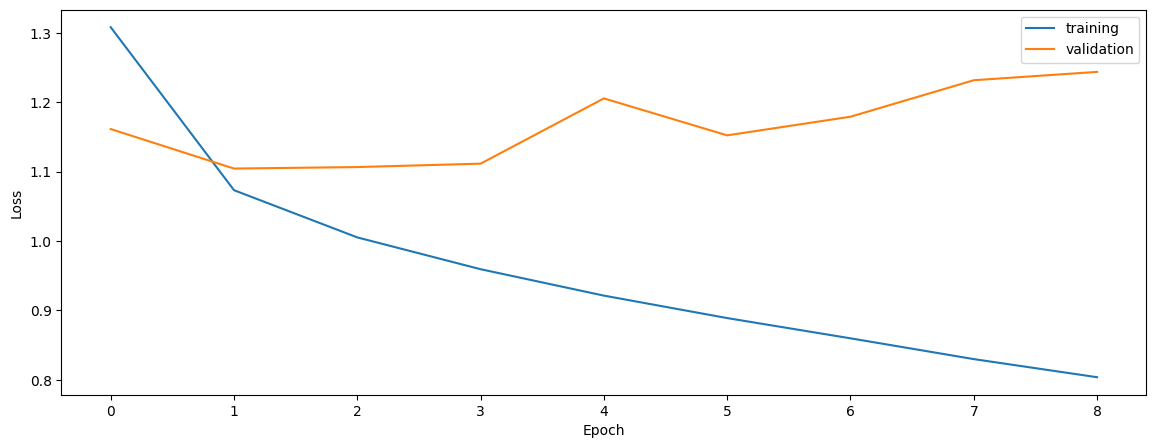

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train


0.5996935804755871
0.5683294398443018
0.5548479645540484


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

native
0.5717415258340683
0.5573617142538548
0.5445433886285744


In [9]:
print('normalized')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.5701849757378963
0.5515237998165324
0.5432911392405063


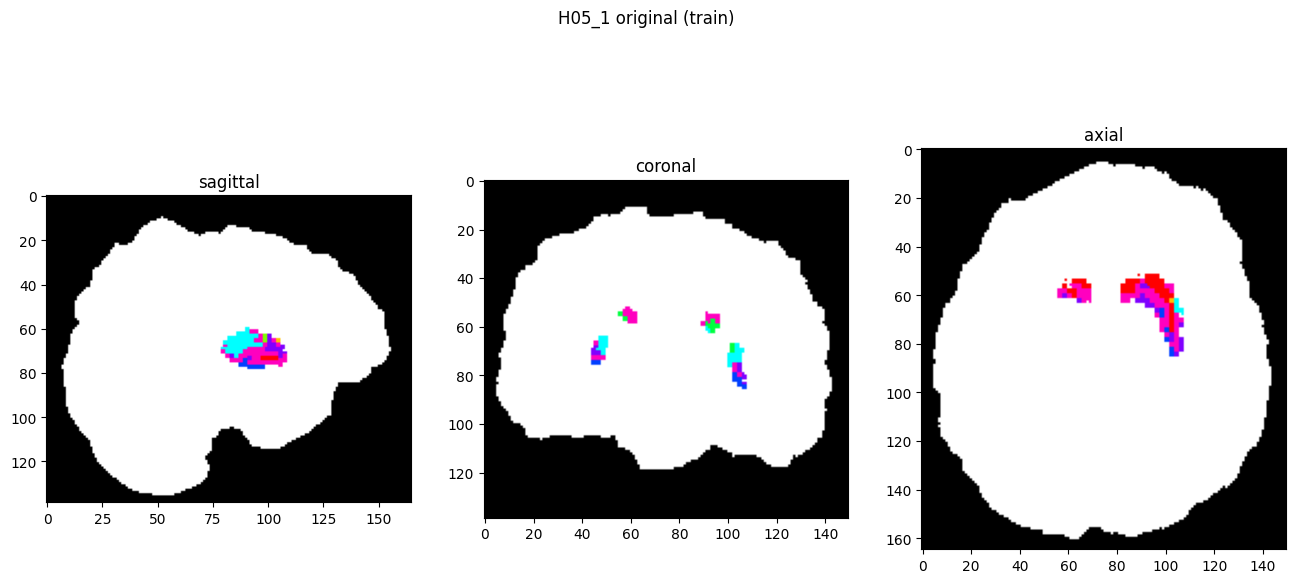

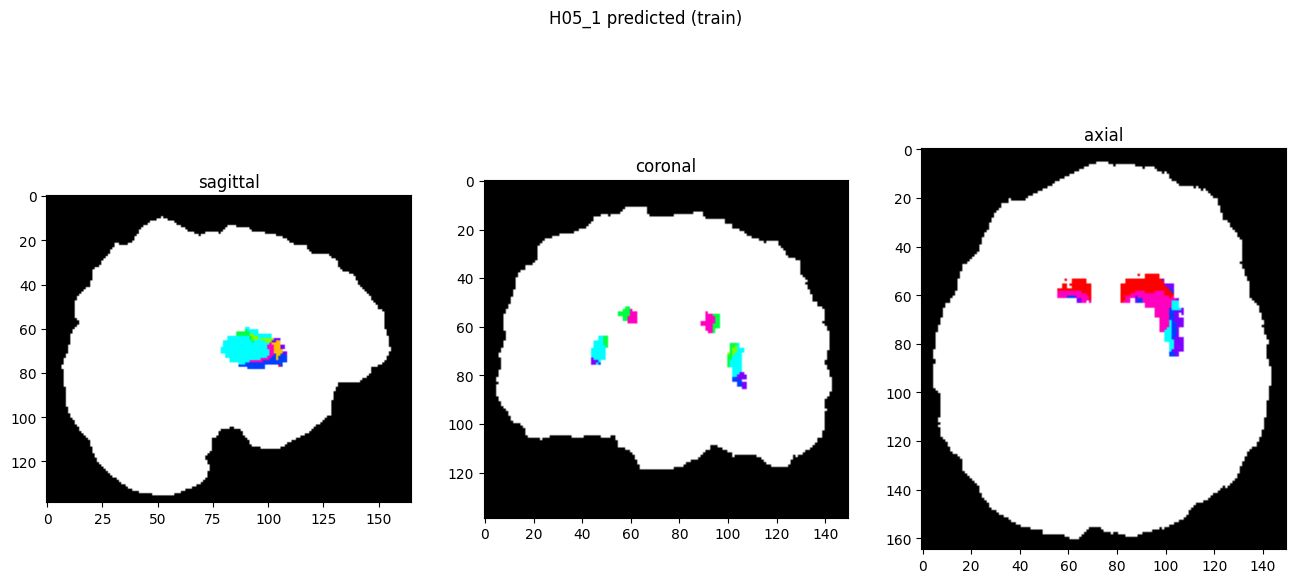

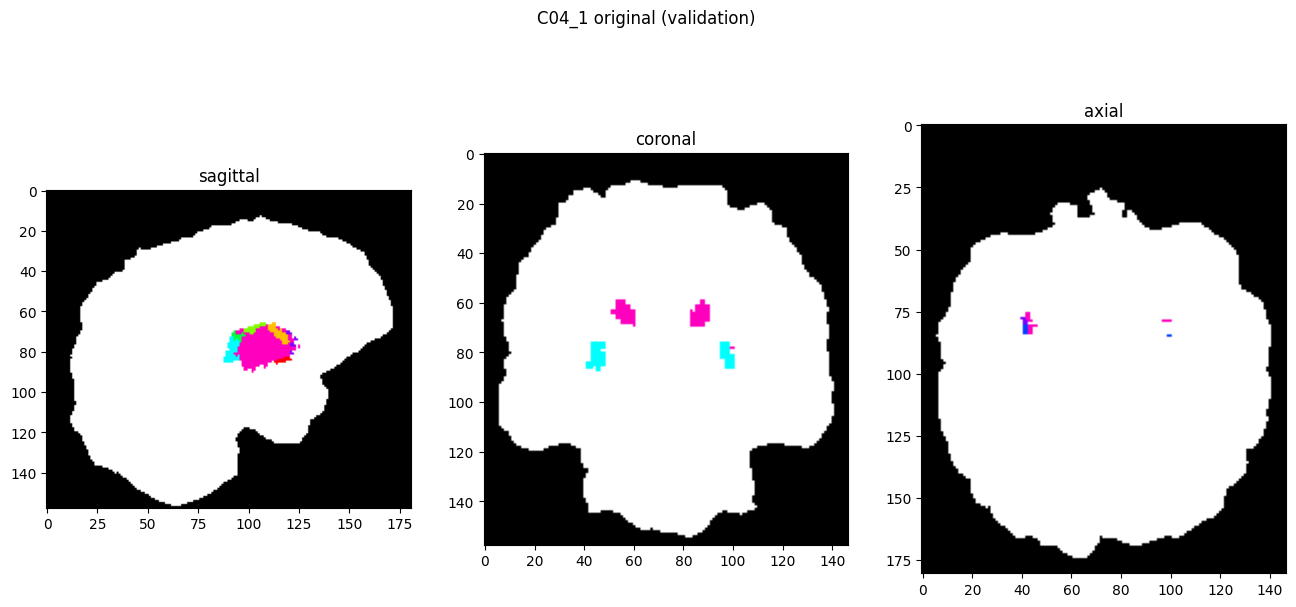

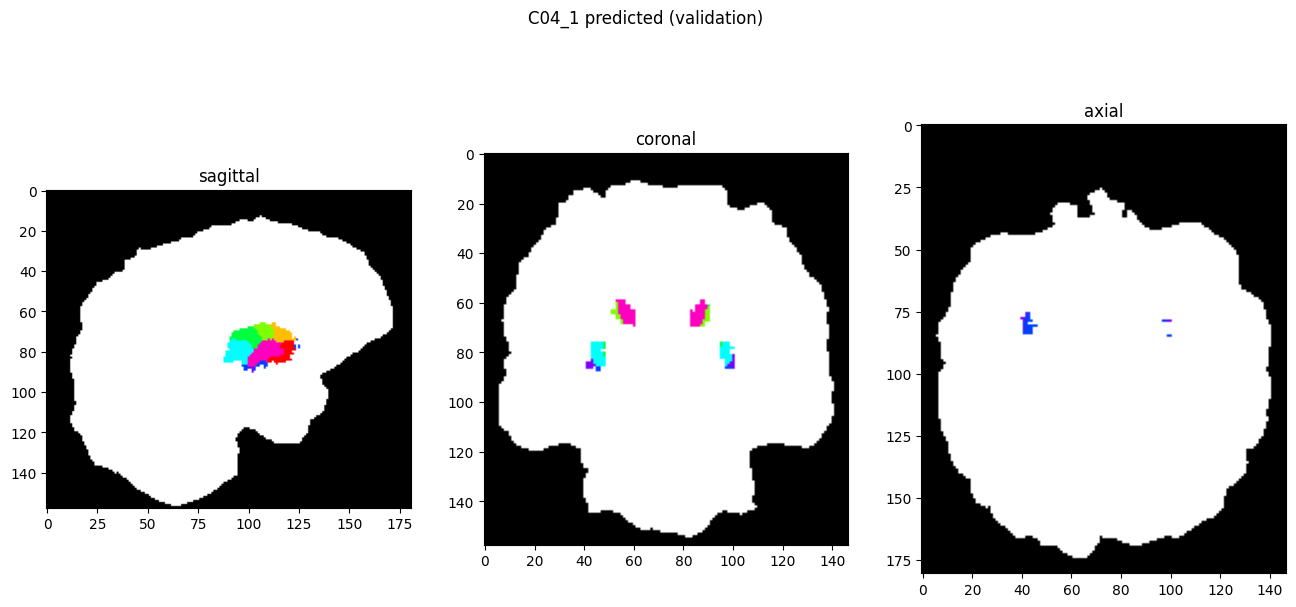

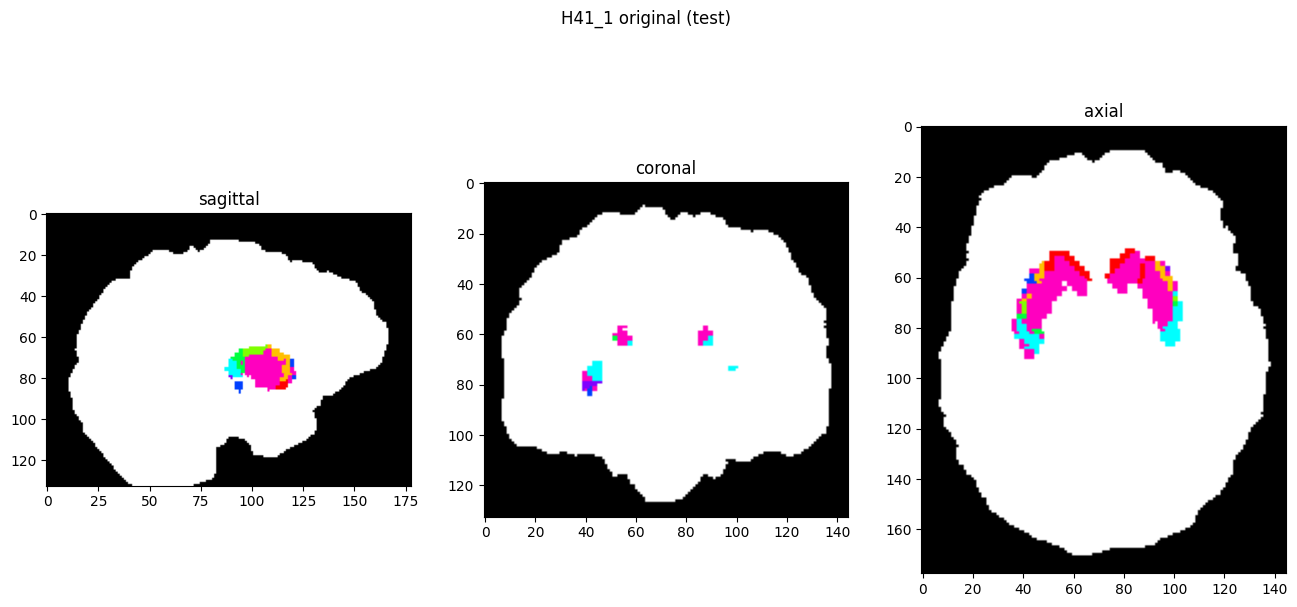

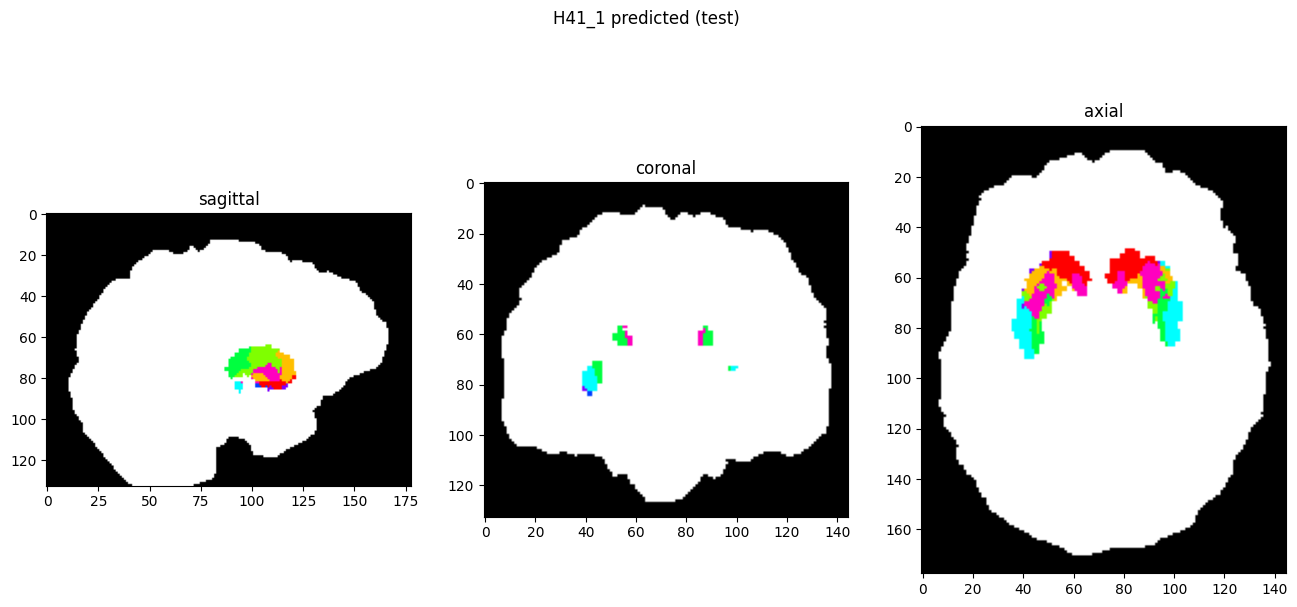

In [10]:
showResults(model, gen, threshold=0)